# Multi Color Light Curves  applied to LATISS


based on notebook from Lauren macArthur


- author Sylvie Dagoret-Campagne
- creation date 2024-04-11
- last update 2024-04-11


  
``Quantum Graphs``: https://tigress-web.princeton.edu/~lkelvin/pipelines/ 


https://tigress-web.princeton.edu/~lkelvin/pipelines/current/drp_pipe/LSSTComCamSim/nightly-validation-ops-rehearsal-3/

``CalibrateTask``: 
https://github.com/lsst/pipe_tasks/blob/main/python/lsst/pipe/tasks/calibrate.py#L392-L399


``Shemas``:
https://dm.lsst.org/sdm_schemas/browser/

In [1]:
from lsst.daf.butler import Butler

import astropy.units as u
import numpy as np 
import pandas as pd
pd.set_option("display.max_columns", None)
from astropy.time import Time

import scipy.stats

import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm,SymLogNorm

import lsst.afw.display.rgb as afwRgb
import lsst.afw.image as afwImage
import lsst.geom as geom
import pickle
from astropy.stats import SigmaClip

In [2]:
#xx-small
#x-small
#small
#medium
#large
#x-large
#xx-large

plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams["axes.labelsize"] = 'x-large'
plt.rcParams['axes.titlesize'] = 'x-large'
plt.rcParams['xtick.labelsize']= 'x-large'
plt.rcParams['ytick.labelsize']= 'x-large'

In [3]:
def get_corners_radec(wcs, bbox):
    """
    Return the corners in RA,Dec in degrees given the WCS and bounding box for an image.

    Parameters
    ----------
    wcs: image WCS returned by the Butler
    bbox: bounding box returned by the Butler

    Returns
    -------
    corners_ra, corners_dec in decimal degrees
    """

    corners_x = [bbox.beginX, bbox.beginX, bbox.endX, bbox.endX]
    corners_y = [bbox.beginY, bbox.endY, bbox.endY, bbox.beginY]
    corners_ra = []
    corners_dec = []
    for i in range(4):
        radec = wcs.pixelToSky(corners_x[i], corners_y[i])
        corners_ra.append(radec.getRa().asDegrees())
        corners_dec.append(radec.getDec().asDegrees())
    
    return corners_ra, corners_dec

In [4]:
saveDir = "./lc_output_dmrehearsal2024-latiss"
doSaveFigs = False  # set to True if you actually want to save the figures in the above dir

In [5]:
# Set some selections for reliable data
minNumMatches = 3
minSnCalibFlux =  100

In [6]:
# INSERT YOUR collection and tract
# for rehearsal use collection 2 which have CCDvisit
butlerRoot = "/repo/embargo"

collection1 = 'LSSTComCamSim/runs/nightlyvalidation/20240402/d_2024_03_29/DM-43612'
collection2 = 'LSSTComCamSim/runs/nightlyvalidation/20240403/d_2024_03_29/DM-43612'
collection3 = 'LSSTComCamSim/runs/nightlyvalidation/20240404/d_2024_03_29/DM-43612'
collection = 'LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240311/w_2024_10/PREOPS-4985'
collectionn = collection
#collections = [collection1,collection2,collection3]
collections = [collection]
collectionStr = collectionn.replace("/", "_")
instrument = 'LATISS'
skymapName = "latiss_v1"
where_clause = "instrument = \'" + instrument+ "\'"
tract = 3864
#band = "r"
suptitle = collectionStr + f" inst = {instrument} tract = {tract}"

calibFluxStr = "apFlux_35_0_instFlux"
calibFluxErrStr = "apFlux_35_0_instFluxErr"
calibFluxMagStr = "apFlux_35_0_instMag"
calibFluxMagErrStr = "apFlux_35_0_instMagErr"

calibFluxCalStr = "apFlux_35_0_calFlux"
calibFluxCalErrStr = "apFlux_35_0_calFluxErr"
calibFluxCalMagStr = "apFlux_35_0_calMag"
calibFluxCalMagErrStr = "apFlux_35_0_calMagErr"

file_output_selectedsources = f"lightcurves-dmrehearsal2024_04_03-latiss-tract{tract}.csv"
fullname_file_output_selectedsources = os.path.join(saveDir,file_output_selectedsources)

## Initiate butler from variables set above

In [7]:
# Initiate butler from variables set above
butler = Butler(butlerRoot, collections=collections, instrument=instrument, skymap=skymapName)
camera = butler.get("camera", instrument=instrument)
skymap = butler.get("skyMap")
print("camera_name = {}".format(camera.getName()))
print("collections = {}".format(collections))

camera_name = LATISS
collections = ['LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240311/w_2024_10/PREOPS-4985']


## load isolated_star_sources

In [8]:
# Try to get the Schema
all_tracts = []
data_product = "isolated_star_sources"
datasetRefs = butler.registry.queryDatasets(datasetType=data_product, collections=collections, where= where_clause)
for i, ref in enumerate(datasetRefs):
    print(i,ref.dataId)
    all_tracts.append(ref.dataId["tract"])
    #butler_data = butler.get(ref)

all_tracts = sorted(all_tracts)
print("all tracts : ", all_tracts)

#if not isinstance(butler_data, pd.core.frame.DataFrame):
#    print(butler_data.getSchema())

0 {instrument: 'LATISS', skymap: 'latiss_v1', tract: 5616}
1 {instrument: 'LATISS', skymap: 'latiss_v1', tract: 10644}
2 {instrument: 'LATISS', skymap: 'latiss_v1', tract: 454}
3 {instrument: 'LATISS', skymap: 'latiss_v1', tract: 3863}
4 {instrument: 'LATISS', skymap: 'latiss_v1', tract: 452}
5 {instrument: 'LATISS', skymap: 'latiss_v1', tract: 10643}
6 {instrument: 'LATISS', skymap: 'latiss_v1', tract: 5615}
7 {instrument: 'LATISS', skymap: 'latiss_v1', tract: 383}
8 {instrument: 'LATISS', skymap: 'latiss_v1', tract: 5839}
9 {instrument: 'LATISS', skymap: 'latiss_v1', tract: 8188}
10 {instrument: 'LATISS', skymap: 'latiss_v1', tract: 455}
11 {instrument: 'LATISS', skymap: 'latiss_v1', tract: 382}
12 {instrument: 'LATISS', skymap: 'latiss_v1', tract: 5614}
13 {instrument: 'LATISS', skymap: 'latiss_v1', tract: 3864}
14 {instrument: 'LATISS', skymap: 'latiss_v1', tract: 5634}
15 {instrument: 'LATISS', skymap: 'latiss_v1', tract: 380}
all tracts :  [380, 382, 383, 452, 454, 455, 3863, 386

## isolated_star_sources Keeping all bands here, but keep the tract selection

The main starting point is the table of isolated_star_sources which has been constructed in step 2a from a catalog
Note that isolated star sources are associated to an object (a static starobject)
Here the work is doneband by band.
It is a good idea to work band by band.

In [9]:
# Load in isolated_star_sources and trim to band of interest and select the tract
isolatedStarSourcesFull = butler.get("isolated_star_sources", tract=tract)
#isolatedStarSourcesFull = isolatedStarSourcesFull[isolatedStarSourcesFull["band"] == band]

In [10]:
tract

3864

In [11]:
len(isolatedStarSourcesFull)

163861

In [12]:
# Just to have a look at what's in the catalog:
isolatedStarSourcesFull[isolatedStarSourcesFull.index == 0]

,index,sourceId,visit,detector,ra,dec,physical_filter,band,apFlux_35_0_instFlux,apFlux_35_0_instFluxErr,x,y,apFlux_50_0_instFlux,apFlux_50_0_instFluxErr,apFlux_50_0_flag,localBackground_instFlux,localBackground_flag,source_row,obj_index
0,720,178244558356742865,2023111500493,0,122.502818,-36.181373,empty~SDSSi_65mm,i,17929.311148,580.063968,3089.020434,3522.956779,18544.821571,817.794717,False,-0.084691,False,720,0


In [13]:
isolatedStarSourcesFull.head()

,index,sourceId,visit,detector,ra,dec,physical_filter,band,apFlux_35_0_instFlux,apFlux_35_0_instFluxErr,x,y,apFlux_50_0_instFlux,apFlux_50_0_instFluxErr,apFlux_50_0_flag,localBackground_instFlux,localBackground_flag,source_row,obj_index
0,720,178244558356742865,2023111500493,0,122.502818,-36.181373,empty~SDSSi_65mm,i,17929.311148,580.063968,3089.020434,3522.956779,18544.821571,817.794717,False,-0.084691,False,720,0
1,657,178244564799193746,2023111500499,0,122.502820,-36.181372,empty~SDSSi_65mm,i,17965.443097,593.565729,1981.052932,3539.433919,18788.373258,839.011243,False,0.049484,False,657,0
2,690,178244568020419251,2023111500502,0,122.502819,-36.181372,empty~SDSSi_65mm,i,17309.856495,581.983397,1425.831515,3545.340924,17906.736267,821.413552,False,0.070277,False,690,0
3,481,178244580905320930,2023111500514,0,122.502817,-36.181374,empty~SDSSi_65mm,i,16563.487123,545.671588,3634.994108,2036.356179,16308.805325,776.241811,False,-0.196106,False,481,0
4,432,178244587347771825,2023111500520,0,122.502822,-36.181372,empty~SDSSi_65mm,i,17951.820662,577.548601,2527.386039,2051.742380,18624.356145,814.688326,False,0.041315,False,432,0


In [14]:
isolatedStarSourcesFull.tail()

,index,sourceId,visit,detector,ra,dec,physical_filter,band,apFlux_35_0_instFlux,apFlux_35_0_instFluxErr,x,y,apFlux_50_0_instFlux,apFlux_50_0_instFluxErr,apFlux_50_0_flag,localBackground_instFlux,localBackground_flag,source_row,obj_index
163856,56,179546353280483385,2023122200468,0,122.636922,-36.166699,empty~SDSSy_65mm,y,6159.305843,570.340900,4029.261883,467.716012,NaN,NaN,True,-0.120178,False,56,1298
163857,6,178913118334746631,2023120400546,0,122.627449,-36.261951,empty~SDSSy_65mm,y,6002.652226,546.429347,3854.516501,69.447705,5149.290161,779.662392,False,-0.179842,False,6,1299
163858,289,181973644384141602,2024022900067,0,122.439252,-36.069256,empty~SDSSy_65mm,y,17046.173911,591.284537,1160.102547,3639.086131,19346.313383,837.526273,False,0.166535,False,289,1300
163859,311,181973652974076216,2024022900075,0,122.477861,-36.067847,empty~SDSSy_65mm,y,17262.146455,589.125479,1210.733303,3710.297643,17597.427159,831.424850,False,0.083739,False,311,1301
163860,149,179159378874597526,2023121100518,0,122.371089,-36.241101,empty~SDSSy_65mm,y,6536.212928,607.428677,112.776400,984.505377,7636.402888,864.654488,False,0.303516,False,149,1302


In [15]:
isolatedStarSourcesFull.columns

Index(['index', 'sourceId', 'visit', 'detector', 'ra', 'dec',
       'physical_filter', 'band', 'apFlux_35_0_instFlux',
       'apFlux_35_0_instFluxErr', 'x', 'y', 'apFlux_50_0_instFlux',
       'apFlux_50_0_instFluxErr', 'apFlux_50_0_flag',
       'localBackground_instFlux', 'localBackground_flag', 'source_row',
       'obj_index'],
      dtype='object')

In [16]:
print(sorted(isolatedStarSourcesFull["visit"].unique()))

[2023111500491, 2023111500492, 2023111500493, 2023111500494, 2023111500495, 2023111500496, 2023111500497, 2023111500498, 2023111500499, 2023111500500, 2023111500501, 2023111500502, 2023111500503, 2023111500504, 2023111500505, 2023111500506, 2023111500507, 2023111500508, 2023111500509, 2023111500510, 2023111500511, 2023111500512, 2023111500513, 2023111500514, 2023111500515, 2023111500516, 2023111500517, 2023111500518, 2023111500519, 2023111500520, 2023111500521, 2023111500522, 2023111500523, 2023111500524, 2023111500525, 2023111500526, 2023111500527, 2023111500528, 2023111500529, 2023111500530, 2023111500531, 2023111500532, 2023111500533, 2023111500534, 2023111500535, 2023111500536, 2023111500537, 2023111500538, 2023111500539, 2023111500540, 2023111500541, 2023111500542, 2023111500543, 2023111500544, 2023111500545, 2023111500546, 2023111500547, 2023111500548, 2023111500549, 2023111500550, 2023111500551, 2023111500552, 2023111500553, 2023111500554, 2023111500555, 2023111500556, 202311150

In [17]:
# Just to have a look at what's in the catalog:
isolatedStarSourcesFull[isolatedStarSourcesFull.index == 0]

,index,sourceId,visit,detector,ra,dec,physical_filter,band,apFlux_35_0_instFlux,apFlux_35_0_instFluxErr,x,y,apFlux_50_0_instFlux,apFlux_50_0_instFluxErr,apFlux_50_0_flag,localBackground_instFlux,localBackground_flag,source_row,obj_index
0,720,178244558356742865,2023111500493,0,122.502818,-36.181373,empty~SDSSi_65mm,i,17929.311148,580.063968,3089.020434,3522.956779,18544.821571,817.794717,False,-0.084691,False,720,0


In [18]:
print("calibFluxStr = {},,minSnCalibFlux = {}, minNumMatches = {}".format(calibFluxStr,minSnCalibFlux,minNumMatches))

calibFluxStr = apFlux_35_0_instFlux,,minSnCalibFlux = 100, minNumMatches = 3


## Select a number of visits with enough good sources but in all bands here

- extract the list of known objects

In [19]:
calibFluxStr

'apFlux_35_0_instFlux'

In [20]:
minSnCalibFlux

100

In [21]:
# Trim the isolated_star_sources cat to those PSF S/N > minSnCalibFlux
# and number of matches sources > minNumMatches.
objIndexListFull = list(set(isolatedStarSourcesFull["obj_index"].values))

# Select the bright stars above a minimum of S/N ratio
if minSnCalibFlux is not None:
    snCalibFlux = isolatedStarSourcesFull[calibFluxStr]/isolatedStarSourcesFull[calibFluxStr + "Err"]
    snMask = snCalibFlux > minSnCalibFlux
    isolatedStarSourcesMinSn = isolatedStarSourcesFull[snMask].copy(deep=True)
else:
    isolatedStarSourcesMinSn = isolatedStarSourcesFull.copy(deep=True)

# object index with obj index in above selected bright selected star
objIndexListMinSn = list(set(isolatedStarSourcesMinSn["obj_index"].values))

# requires that the object is associated to several sources (at least minNumMatches sources)
# loop on object having sources with S/N aboe selection 
objIndexList = []
for objIndex in objIndexListMinSn:
    objData = isolatedStarSourcesMinSn[isolatedStarSourcesMinSn["obj_index"] == objIndex]
    if len(objData) >= minNumMatches:
        objIndexList.append(objIndex)
numTrimmed = len(objIndexListFull) - len(objIndexList)

mask = []
for objIndex, visit in zip(isolatedStarSourcesMinSn["obj_index"], isolatedStarSourcesMinSn["visit"]):
    if objIndex in objIndexList:
        mask.append(True)
    else:
        mask.append(False)
isolatedStarSources = isolatedStarSourcesMinSn[mask].copy(deep=True)

# Select a number of visits according quality criteria
visitList = list(set(isolatedStarSources["visit"].values))

if minSnCalibFlux is not None:
    print("Trimmed isolated_star_sources catalog to S/N {} > {} (leaving N={} matched sources from original {})".format(
        calibFluxStr, minSnCalibFlux, len(isolatedStarSources), len(isolatedStarSourcesFull)))
print("Trimmed isolated_star_sources catalog to objecst with nMatches >= {} (leaving {} objects from {}).".format(
    minNumMatches, len(objIndexList), len(objIndexListFull)))

Trimmed isolated_star_sources catalog to S/N apFlux_35_0_instFlux > 100 (leaving N=25780 matched sources from original 163861)
Trimmed isolated_star_sources catalog to objecst with nMatches >= 3 (leaving 190 objects from 1303).


In [22]:
sorted_visitList = sorted(visitList)
sorted_visitList 

[2023111500491,
 2023111500492,
 2023111500493,
 2023111500494,
 2023111500495,
 2023111500496,
 2023111500497,
 2023111500498,
 2023111500499,
 2023111500500,
 2023111500501,
 2023111500502,
 2023111500503,
 2023111500504,
 2023111500505,
 2023111500506,
 2023111500507,
 2023111500508,
 2023111500509,
 2023111500510,
 2023111500511,
 2023111500512,
 2023111500513,
 2023111500514,
 2023111500515,
 2023111500516,
 2023111500517,
 2023111500518,
 2023111500519,
 2023111500520,
 2023111500521,
 2023111500522,
 2023111500523,
 2023111500524,
 2023111500525,
 2023111500526,
 2023111500527,
 2023111500528,
 2023111500529,
 2023111500530,
 2023111500531,
 2023111500532,
 2023111500533,
 2023111500534,
 2023111500535,
 2023111500536,
 2023111500537,
 2023111500538,
 2023111500539,
 2023111500540,
 2023111500541,
 2023111500542,
 2023111500543,
 2023111500544,
 2023111500545,
 2023111500546,
 2023111500547,
 2023111500548,
 2023111500549,
 2023111500550,
 2023111500551,
 2023111500552,
 2023111

In [23]:
def convertVisitToDatestr(visit):

    num = visit//100_000
    year = num//10_000
    month= (num-year*10_000)//100
    day = (num-year*10_000-month*100)

    year_str = str(year).zfill(4)
    month_str = str(month).zfill(2)
    day_str = str(day).zfill(2)
    
    datestr = f"{year_str}-{month_str}-{day_str}"
    return datestr

In [24]:
def convertVisitToMJD(visit):
    return Time(convertVisitToDatestr(visit)).mjd

In [25]:
sorted_visits_mjd = list(map(convertVisitToMJD, sorted_visitList))

## sourceTable_visit

This is the main output of FGCM calibration which has selected a number of sources. These sources were originally selected from isolated sources.

In [26]:
# Extra columns to load from sourceTable_visit catalogs
names = ["psfFlux", "psfFluxErr", "psfFlux_flag", "psfFlux_apCorr", "psfFlux_apCorrErr",
         "extendedness", "detect_isPrimary", "deblend_skipped",
         "gaussianFlux", "gaussianFluxErr", "gaussianFlux_flag",
         "localPhotoCalib", "localPhotoCalibErr", "localPhotoCalib_flag"]

## Note that some sourceTable_visit not found for some visits in isolated_star_sources 

In [27]:
visitList

[2023112900608,
 2023112900609,
 2023112900610,
 2023112900611,
 2023112900612,
 2023112900613,
 2023112900614,
 2023112900615,
 2023112900616,
 2023112900617,
 2023112900618,
 2023112900619,
 2023121500480,
 2023112900621,
 2023112900622,
 2023112900623,
 2024030400220,
 2023112900625,
 2023112900626,
 2023112900627,
 2023112900620,
 2023121500482,
 2023112900630,
 2023112900631,
 2023112900629,
 2023112900633,
 2023112900634,
 2023112900635,
 2023121500483,
 2023112900632,
 2023112900636,
 2023121500487,
 2024013000130,
 2023121500491,
 2023121500495,
 2023121500496,
 2023121500499,
 2023121500500,
 2023121500501,
 2023121500502,
 2023121500503,
 2023121500504,
 2024013000146,
 2023121500507,
 2023121500508,
 2023121500511,
 2023121500512,
 2023122000188,
 2023121500519,
 2024030200024,
 2024030200025,
 2024030200026,
 2024030200027,
 2024030200028,
 2024030200029,
 2024030200031,
 2024030200032,
 2024030200033,
 2023121500523,
 2024030200036,
 2024030200035,
 2024030200037,
 2024030

In [28]:
# Load in the sourceTable_visit catalogs to get the psfFlux and other useful info per source.
# Columns loaded are those in names above.
sourceCatalogs = []
nSourceDict = {}
visitsToRemove = []

# loop over all selected visit
for visit in visitList:
    try:
        sourceCatalogOrig = butler.get("sourceTable_visit", visit=visit, parameters={"columns": names})
        primaryCat = sourceCatalogOrig[sourceCatalogOrig["detect_isPrimary"]].copy(deep=True)
        nSourceDict[visit] = sum(primaryCat["psfFlux"]/primaryCat["psfFluxErr"] > 5)
        sourceCatalogs.append(primaryCat)
    except LookupError:
        print("sourceTable_visit not found for visit {}".format(visit))
        isolatedStarSources = isolatedStarSources[isolatedStarSources["visit"] != visit].copy(deep=True)
        visitsToRemove.append(visit)
visitList = list(set(visitList) - set(visitsToRemove))

# Do the minNumMatches cut again since visits may have been removed due to lack of sourceTable_visit
print("Number of objects with >=3 matches before sourceTable_visit exsistence check: {}".format(len(objIndexList)))
objIndexListAllNew = list(set(isolatedStarSources["obj_index"].values))
objIndexList = []
for objIndex in objIndexListAllNew:
    objData = isolatedStarSources[isolatedStarSources["obj_index"] == objIndex]
    if len(objData) >= minNumMatches:
        objIndexList.append(objIndex)
mask = []
for objIndex, visit in zip(isolatedStarSources["obj_index"], isolatedStarSources["visit"]):
    if objIndex in objIndexList:
        mask.append(True)
    else:
        mask.append(False)
isolatedStarSources = isolatedStarSources[mask].copy(deep=True)
visitList = list(set(isolatedStarSources["visit"].values))
print("Number of objects with >=3 matches after sourceTable_visit exsistence check: {}".format(len(objIndexList)))
dataJoined = pd.concat(sourceCatalogs).merge(isolatedStarSources, on="sourceId", how="inner")

sourceTable_visit not found for visit 2024030200026
sourceTable_visit not found for visit 2024030200038
sourceTable_visit not found for visit 2024030200049
sourceTable_visit not found for visit 2024030200050
sourceTable_visit not found for visit 2024020600055
sourceTable_visit not found for visit 2024021900278
sourceTable_visit not found for visit 2023113000528
sourceTable_visit not found for visit 2023113000529
sourceTable_visit not found for visit 2024012900356
sourceTable_visit not found for visit 2024022600054
sourceTable_visit not found for visit 2024022600055
sourceTable_visit not found for visit 2023111600631
sourceTable_visit not found for visit 2023111600640
sourceTable_visit not found for visit 2023111600684
sourceTable_visit not found for visit 2023111600702
sourceTable_visit not found for visit 2024030700246
sourceTable_visit not found for visit 2024020700277
sourceTable_visit not found for visit 2024020700286
sourceTable_visit not found for visit 2024020700303
sourceTable_

In [29]:
len(sourceCatalogs)

2517

In [30]:
nSourceDict

{2023112900608: 487,
 2023112900609: 435,
 2023112900610: 703,
 2023112900611: 700,
 2023112900612: 557,
 2023112900613: 437,
 2023112900614: 723,
 2023112900615: 933,
 2023112900616: 533,
 2023112900617: 435,
 2023112900618: 638,
 2023112900619: 822,
 2023121500480: 465,
 2023112900621: 357,
 2023112900622: 603,
 2023112900623: 760,
 2024030400220: 320,
 2023112900625: 293,
 2023112900626: 531,
 2023112900627: 774,
 2023112900620: 514,
 2023121500482: 965,
 2023112900630: 630,
 2023112900631: 777,
 2023112900629: 406,
 2023112900633: 385,
 2023112900634: 628,
 2023112900635: 847,
 2023121500483: 576,
 2023112900632: 462,
 2023112900636: 518,
 2023121500487: 606,
 2024013000130: 357,
 2023121500491: 615,
 2023121500495: 628,
 2023121500496: 514,
 2023121500499: 642,
 2023121500500: 471,
 2023121500501: 714,
 2023121500502: 1002,
 2023121500503: 693,
 2023121500504: 458,
 2024013000146: 494,
 2023121500507: 466,
 2023121500508: 461,
 2023121500511: 567,
 2023121500512: 454,
 20231220001

In [31]:
visitList

[2023112900608,
 2023112900609,
 2023112900610,
 2023112900611,
 2023112900612,
 2023112900613,
 2023112900614,
 2023112900615,
 2023112900616,
 2023112900617,
 2023112900618,
 2023112900619,
 2023121500480,
 2023112900621,
 2023112900622,
 2023112900623,
 2024030400220,
 2023112900625,
 2023112900626,
 2023112900627,
 2023112900620,
 2023121500482,
 2023112900630,
 2023112900631,
 2023112900629,
 2023112900633,
 2023112900634,
 2023112900635,
 2023121500483,
 2023112900632,
 2023112900636,
 2023121500487,
 2024013000130,
 2023121500491,
 2023121500495,
 2023121500496,
 2023121500499,
 2023121500500,
 2023121500501,
 2023121500502,
 2023121500503,
 2023121500504,
 2024013000146,
 2023121500507,
 2023121500508,
 2023121500511,
 2023121500512,
 2023122000188,
 2023121500519,
 2024030200024,
 2024030200025,
 2024030200027,
 2024030200028,
 2024030200029,
 2024030200031,
 2024030200032,
 2024030200033,
 2023121500523,
 2024030200036,
 2024030200035,
 2024030200037,
 2024030200039,
 2024030

In [32]:
visitsToRemove 

[2024030200026,
 2024030200038,
 2024030200049,
 2024030200050,
 2024020600055,
 2024021900278,
 2023113000528,
 2023113000529,
 2024012900356,
 2024022600054,
 2024022600055,
 2023111600631,
 2023111600640,
 2023111600684,
 2023111600702,
 2024030700246,
 2024020700277,
 2024020700286,
 2024020700303,
 2024020700305,
 2024020700306,
 2024020700317,
 2024020700318,
 2024020700331,
 2024020700334,
 2024020700339,
 2024020700349,
 2024020700358,
 2024020800024,
 2024020800027,
 2024020800043,
 2024020800047,
 2024020800055,
 2024020800056,
 2024020800057,
 2024020800060,
 2024020800062,
 2024020800064,
 2024020800072,
 2023121900370,
 2024030200081,
 2024030700290,
 2024022900080]

## Will start to work on dataJoined which associate selected "isolated_star_sources" in the selected band and visits the good calibration in "sourceTable_visit"

### add my info from CCD Visit Table

- CCD visit table is a pre-FGCM calibration
- it provides airmass and initial zero-point

In [33]:
# need also. ["zeroPoint","airmass"]

In [34]:
# Collect useful columns from ccdVisitTable
visitsCCDToRemove = []


ccdVisitTable = butler.get("ccdVisitTable")
ccdVisitTable["airmass"] = ccdVisitTable["zenithDistance"].apply(lambda x: 1/np.cos(np.pi/180.*x))
ccdVisitTable["medianE"] = np.sqrt(ccdVisitTable["psfStarDeltaE1Median"] ** 2.0 + 
                                    ccdVisitTable["psfStarDeltaE2Median"] ** 2.0)
psfSigmaDict = {}
skyBgDict = {}
skyNoiseDict = {}
expTimeDict = {}
expMidptMjdDict = {}
medianEDict = {}
psfStarScaledDeltaSizeScatterDict = {}
astromOffsetStdDict = {}
psfTraceRadiusDeltaDict = {}
zeroPointDict = {}
airmassDict = {}
seeingDict = {}
#localCalibDict = {}
#DZPDict = {}
# for visit in ccdVisitTable["visitId"].values:
#     if visit in visitList:
for visit in visitList:
    if visit in ccdVisitTable["visitId"].values:
        psfSigmaDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["psfSigma"].values[0]
        skyBgDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["skyBg"].values[0]
        skyNoiseDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["skyNoise"].values[0]
        expTimeDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["expTime"].values[0]
        expMidptMjdDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["expMidptMJD"].values[0]
        medianEDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["medianE"].values[0]
        psfStarScaledDeltaSizeScatterDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["psfStarScaledDeltaSizeScatter"].values[0]
        astromOffsetStdDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["astromOffsetStd"].values[0]
        psfTraceRadiusDeltaDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["psfTraceRadiusDelta"].values[0]
        zeroPointDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["zeroPoint"].values[0]
        airmassDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["airmass"].values[0]
        seeingDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["seeing"].values[0]
#        DZPDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["DZP"].values[0]
    else:
        #raise RuntimeError("ERROR: visit {} not found in ccdVisitTable".format(visit))
        print("ERROR: CCD visit {} not found in ccdVisitTable".format(visit))
        visitsCCDToRemove.append(visit) 
        psfSigmaDict[visit] = np.nan
        skyBgDict[visit] = np.nan
        skyNoiseDict[visit] = np.nan
        expTimeDict[visit] = np.nan
        expMidptMjdDict[visit] = np.nan
        medianEDict[visit] = np.nan
        psfStarScaledDeltaSizeScatterDict[visit] = np.nan
        astromOffsetStdDict[visit] = np.nan
        psfTraceRadiusDeltaDict[visit] = np.nan
        zeroPointDict[visit] = np.nan
        airmassDict[visit] = np.nan
        seeingDict[visit] = np.nan

In [35]:
visitList

[2023112900608,
 2023112900609,
 2023112900610,
 2023112900611,
 2023112900612,
 2023112900613,
 2023112900614,
 2023112900615,
 2023112900616,
 2023112900617,
 2023112900618,
 2023112900619,
 2023121500480,
 2023112900621,
 2023112900622,
 2023112900623,
 2024030400220,
 2023112900625,
 2023112900626,
 2023112900627,
 2023112900620,
 2023121500482,
 2023112900630,
 2023112900631,
 2023112900629,
 2023112900633,
 2023112900634,
 2023112900635,
 2023121500483,
 2023112900632,
 2023112900636,
 2023121500487,
 2024013000130,
 2023121500491,
 2023121500495,
 2023121500496,
 2023121500499,
 2023121500500,
 2023121500501,
 2023121500502,
 2023121500503,
 2023121500504,
 2024013000146,
 2023121500507,
 2023121500508,
 2023121500511,
 2023121500512,
 2023122000188,
 2023121500519,
 2024030200024,
 2024030200025,
 2024030200027,
 2024030200028,
 2024030200029,
 2024030200031,
 2024030200032,
 2024030200033,
 2023121500523,
 2024030200036,
 2024030200035,
 2024030200037,
 2024030200039,
 2024030

In [36]:
visitsToRemove 

[2024030200026,
 2024030200038,
 2024030200049,
 2024030200050,
 2024020600055,
 2024021900278,
 2023113000528,
 2023113000529,
 2024012900356,
 2024022600054,
 2024022600055,
 2023111600631,
 2023111600640,
 2023111600684,
 2023111600702,
 2024030700246,
 2024020700277,
 2024020700286,
 2024020700303,
 2024020700305,
 2024020700306,
 2024020700317,
 2024020700318,
 2024020700331,
 2024020700334,
 2024020700339,
 2024020700349,
 2024020700358,
 2024020800024,
 2024020800027,
 2024020800043,
 2024020800047,
 2024020800055,
 2024020800056,
 2024020800057,
 2024020800060,
 2024020800062,
 2024020800064,
 2024020800072,
 2023121900370,
 2024030200081,
 2024030700290,
 2024022900080]

In [37]:
# Just to have a look at what's in the catalog:
ccdVisitTable[ccdVisitTable.index == ccdVisitTable.index[0]] 

,visitId,physical_filter,band,ra,dec,zenithDistance,zeroPoint,psfSigma,skyBg,skyNoise,astromOffsetMean,astromOffsetStd,nPsfStar,psfStarDeltaE1Median,psfStarDeltaE2Median,psfStarDeltaE1Scatter,psfStarDeltaE2Scatter,psfStarDeltaSizeMedian,psfStarDeltaSizeScatter,psfStarScaledDeltaSizeScatter,psfTraceRadiusDelta,maxDistToNearestPsf,effTime,effTimePsfSigmaScale,effTimeSkyBgScale,effTimeZeroPointScale,decl,detector,seeing,skyRotation,expMidpt,expMidptMJD,expTime,obsStart,obsStartMJD,darkTime,xSize,ySize,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec,airmass,medianE
ccdVisitId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
40919696896,2023051100262,SDSSr_65mm~empty,r,239.946728,-24.053747,56.749516,27.697306,7.760594,11.193549,7.8568,0.025776,0.014186,27,-0.002812,-0.001684,0.028204,0.007311,0.066781,0.043159,0.005508,0.449597,1922.977051,0.213347,0.016604,2.680115,0.15981,-24.053747,0,1.749004,322.911701,2023-05-12 01:08:56.302993,60076.047874,30.0,2023-05-12 01:08:41.302993,60076.0477,30.2434,4071,3999,239.935567,-24.128923,240.029265,-24.062575,239.957875,-23.97857,239.864202,-24.044874,1.823818,0.003278


### Plot visits versus time

In [38]:
ccdVisitTable_subset = ccdVisitTable[["visitId","band","zeroPoint","psfSigma","skyBg","skyNoise","seeing","expMidptMJD","obsStart","airmass","llcra","llcdec","ulcra","ulcdec","urcra","urcdec","lrcra","lrcdec"]]

#### compute nightObs and datetime time

In [39]:
ccdVisitTable_subset["nightObs"] =ccdVisitTable_subset.apply(lambda x: x['visitId']//100_000, axis=1)
ccdVisitTable_subset["Time"] = pd.to_datetime(ccdVisitTable_subset['obsStart'])

/tmp/ipykernel_50248/2741161870.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ccdVisitTable_subset["nightObs"] =ccdVisitTable_subset.apply(lambda x: x['visitId']//100_000, axis=1)
/tmp/ipykernel_50248/2741161870.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ccdVisitTable_subset["Time"] = pd.to_datetime(ccdVisitTable_subset['obsStart'])


In [40]:
ccdVisitTable_g = ccdVisitTable_subset[ccdVisitTable_subset.band== "g"]
ccdVisitTable_r = ccdVisitTable_subset[ccdVisitTable_subset.band== "r"]
ccdVisitTable_i = ccdVisitTable_subset[ccdVisitTable_subset.band== "i"]
ccdVisitTable_z = ccdVisitTable_subset[ccdVisitTable_subset.band== "z"]
ccdVisitTable_y = ccdVisitTable_subset[ccdVisitTable_subset.band== "y"]

In [41]:
ccdVisitTable_subset.head()

,visitId,band,zeroPoint,psfSigma,skyBg,skyNoise,seeing,expMidptMJD,obsStart,airmass,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec,nightObs,Time
ccdVisitId,,,,,,,,,,,,,,,,,,,,
40919696896,2023051100262,r,27.697306,7.760594,11.193549,7.856800,1.749004,60076.047874,2023-05-12 01:08:41.302993,1.823818,239.935567,-24.128923,240.029265,-24.062575,239.957875,-23.978570,239.864202,-24.044874,20230511,2023-05-12 01:08:41.302993
40919697408,2023051100264,i,27.838850,6.321881,28.073927,8.586373,1.424821,60076.052140,2023-05-12 01:14:49.912000,1.762794,239.985571,-23.974553,239.869115,-23.994653,239.890710,-24.099127,240.007258,-24.079012,20230511,2023-05-12 01:14:49.912000
40919698432,2023051100268,r,27.716721,8.038972,10.700970,7.854424,1.811649,60076.055316,2023-05-12 01:19:24.311494,1.721301,239.951871,-24.120505,240.046767,-24.055593,239.976942,-23.970518,239.882074,-24.035387,20230511,2023-05-12 01:19:24.311494
40919698944,2023051100270,i,27.858833,6.754847,23.952974,8.440454,1.522426,60076.057363,2023-05-12 01:22:21.150002,1.695170,240.008535,-23.984061,239.892085,-24.004162,239.913693,-24.108652,240.030234,-24.088534,20230511,2023-05-12 01:22:21.150002
40919699200,2023051100271,i,27.826286,6.488425,23.321407,8.416399,1.462219,60076.058878,2023-05-12 01:24:32.058502,1.677014,239.964342,-24.126362,240.059682,-24.062017,239.990410,-23.976542,239.895100,-24.040845,20230511,2023-05-12 01:24:32.058502


In [42]:
ccdVisitTable_subset.tail()

,visitId,band,zeroPoint,psfSigma,skyBg,skyNoise,seeing,expMidptMJD,obsStart,airmass,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec,nightObs,Time
ccdVisitId,,,,,,,,,,,,,,,,,,,,
43453134336,2024030800566,y,26.166447,4.858362,13.559249,8.029708,1.094969,60378.247447,2024-03-09 05:56:04.403505,1.628972,122.426835,-36.257489,122.561095,-36.256166,122.559331,-36.149845,122.425254,-36.151166,20240308,2024-03-09 05:56:04.403505
43453134592,2024030800567,g,27.953827,6.890330,3.249260,7.539632,1.553279,60378.248624,2024-03-09 05:57:46.104001,1.640791,122.444307,-36.257399,122.578585,-36.256079,122.576821,-36.149726,122.442725,-36.151044,20240308,2024-03-09 05:57:46.104001
43453134848,2024030800568,r,27.774017,6.158408,6.951125,7.735226,1.388087,60378.249164,2024-03-09 05:58:32.775498,1.646516,122.444537,-36.257436,122.578805,-36.256104,122.577046,-36.149772,122.442960,-36.151103,20240308,2024-03-09 05:58:32.775498
43453135104,2024030800569,z,27.314375,5.293322,16.513548,8.214679,1.193113,60378.249704,2024-03-09 05:59:19.465993,1.652293,122.444783,-36.257474,122.579046,-36.256150,122.577282,-36.149812,122.443202,-36.151133,20240308,2024-03-09 05:59:19.465993
43453135360,2024030800570,y,26.234928,5.417888,14.284846,8.045543,1.221227,60378.250260,2024-03-09 06:00:07.432002,1.658276,122.445158,-36.257498,122.579434,-36.256166,122.577677,-36.149831,122.443583,-36.151162,20240308,2024-03-09 06:00:07.432002


In [43]:
# function of time conversion
from astropy.time import Time

def dt_to_mjd(dt):
    t = Time(dt)
    return t.to_value('mjd','float')

def mjd_to_dt(mjd):
    tm = Time(mjd, format='mjd')
    # Convert to datetime
    utc =tm.to_datetime()
    return utc

In [44]:
dt = ccdVisitTable_subset.iloc[0]['Time']
dt

Timestamp('2023-05-12 01:08:41.302993')

In [45]:
type(dt)

pandas._libs.tslibs.timestamps.Timestamp

In [46]:
mjd = dt_to_mjd(dt)
mjd

60076.04770026612

In [47]:
tm = mjd_to_dt(mjd)

In [48]:
#ax.secondary_xaxis?

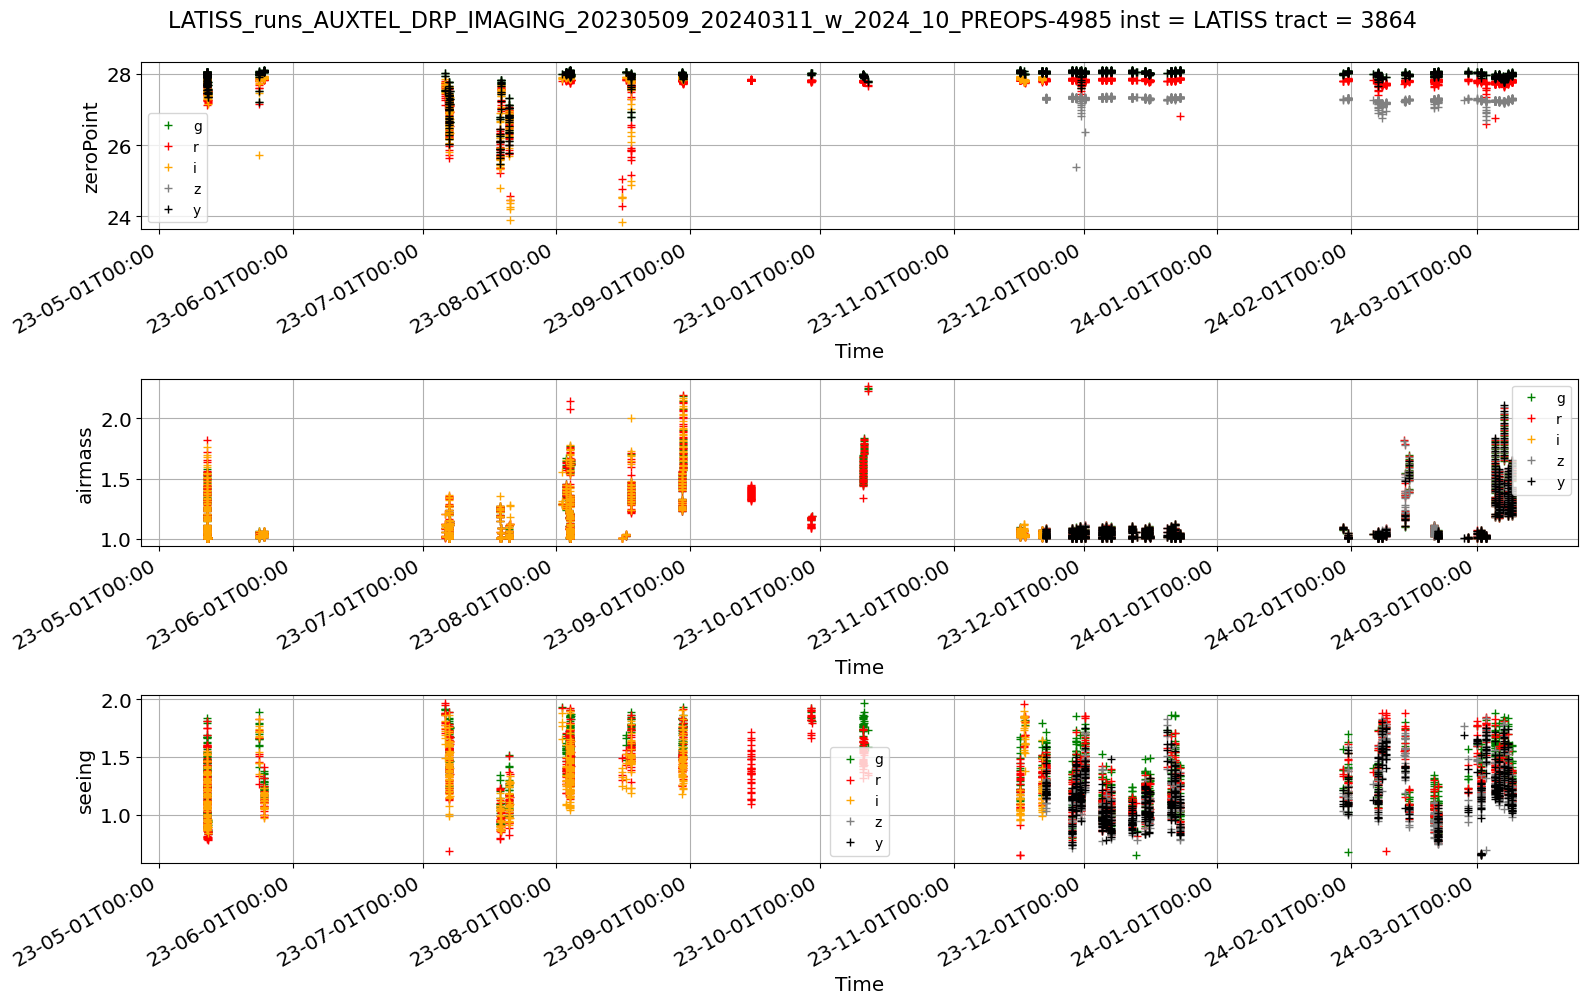

In [49]:
from matplotlib.dates import DateFormatter
date_form = DateFormatter("%y-%m-%dT%H:%M")

fig,axs = plt.subplots(3,1,figsize=(16,10))
ax1,ax2,ax3 = axs
ccdVisitTable_g.plot(x="Time",y="zeroPoint",marker='+',c="g",lw=0.0,ax=ax1,grid=True,label="g")
ccdVisitTable_r.plot(x="Time",y="zeroPoint",marker='+',c="r",lw=0.0,ax=ax1,grid=True,label="r")
ccdVisitTable_i.plot(x="Time",y="zeroPoint",marker='+',c="orange",lw=0.0,ax=ax1,grid=True,label="i")
ccdVisitTable_z.plot(x="Time",y="zeroPoint",marker='+',c="grey",lw=0.0,ax=ax1,grid=True,label="z")
ccdVisitTable_g.plot(x="Time",y="zeroPoint",marker='+',c="k",lw=0.0,ax=ax1,grid=True,label="y")
ax1.set_ylabel("zeroPoint")
ax1.xaxis.set_major_formatter(date_form)
#ax1_up = ax1.secondary_xaxis("top", functions=( dt_to_mjd, mjd_to_dt))
#ccdVisitTable_g.plot(x="expMidptMJD",y="zeroPoint",marker='+',c="g",lw=0.0,ax=ax1_up,grid=True,label="g")


ccdVisitTable_g.plot(x="Time",y="airmass",marker='+',c="g",lw=0.0,ax=ax2,grid=True,label="g")
ccdVisitTable_r.plot(x="Time",y="airmass",marker='+',c="r",lw=0.0,ax=ax2,grid=True,label="r")
ccdVisitTable_i.plot(x="Time",y="airmass",marker='+',c="orange",lw=0.0,ax=ax2,grid=True,label="i")
ccdVisitTable_z.plot(x="Time",y="airmass",marker='+',c="grey",lw=0.0,ax=ax2,grid=True,label="z")
ccdVisitTable_y.plot(x="Time",y="airmass",marker='+',c="k",lw=0.0,ax=ax2,grid=True,label="y")
ax2.set_ylabel("airmass")
ax2.xaxis.set_major_formatter(date_form)

ccdVisitTable_g.plot(x="Time",y="seeing",marker='+',c="g",lw=0.0,ax=ax3,grid=True,label="g")
ccdVisitTable_r.plot(x="Time",y="seeing",marker='+',c="r",lw=0.0,ax=ax3,grid=True,label="r")
ccdVisitTable_i.plot(x="Time",y="seeing",marker='+',c="orange",lw=0.0,ax=ax3,grid=True,label="i")
ccdVisitTable_z.plot(x="Time",y="seeing",marker='+',c="grey",lw=0.0,ax=ax3,grid=True,label="z")
ccdVisitTable_y.plot(x="Time",y="seeing",marker='+',c="k",lw=0.0,ax=ax3,grid=True,label="y")
ax3.set_ylabel("seeing")
ax3.xaxis.set_major_formatter(date_form)




#df.plot(x="Time",y="coord_dec",marker='o',c="g",lw=0.0,ax=ax2,grid=True)
plt.suptitle(suptitle,y=1.0,fontsize=16)
plt.tight_layout()



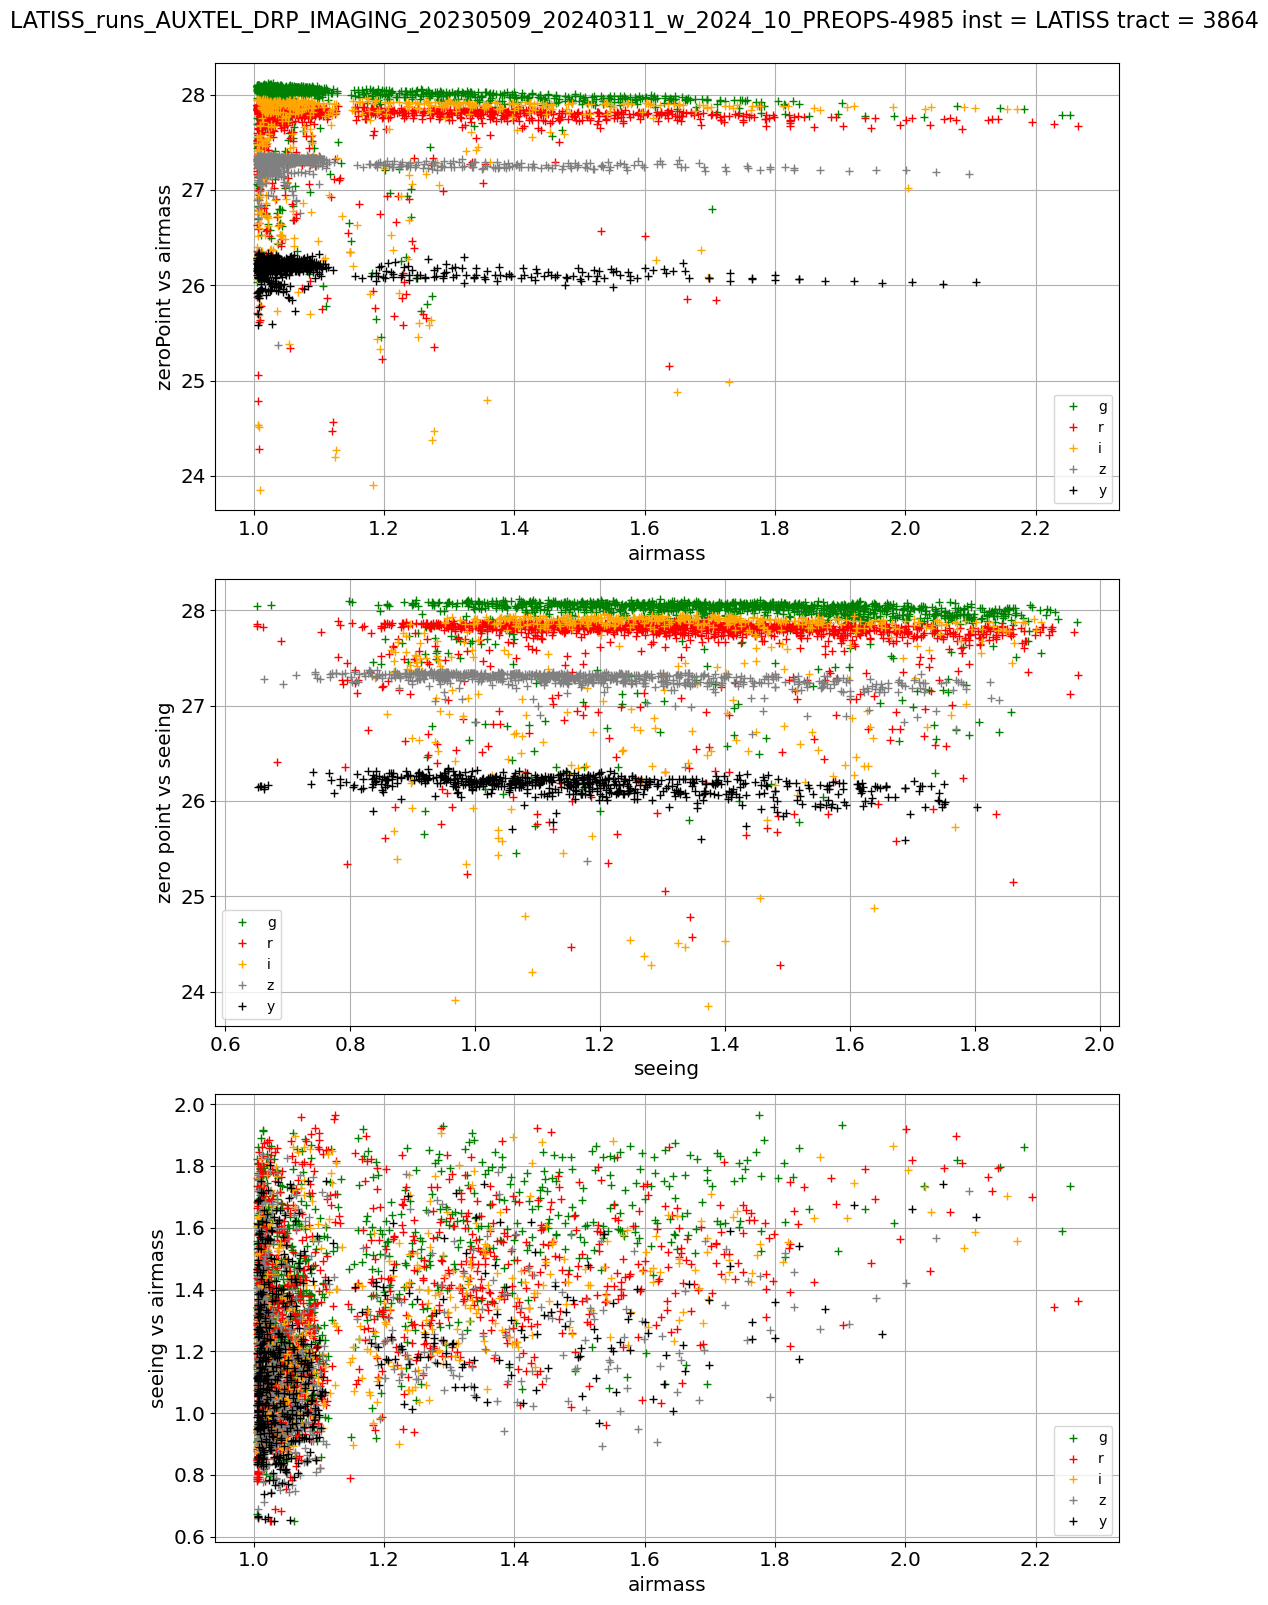

In [50]:
fig,axs = plt.subplots(3,1,figsize=(10,16))
ax1,ax2,ax3 = axs
ccdVisitTable_g.plot(x="airmass",y="zeroPoint",marker='+',c="g",lw=0.0,ax=ax1,grid=True,label="g")
ccdVisitTable_r.plot(x="airmass",y="zeroPoint",marker='+',c="r",lw=0.0,ax=ax1,grid=True,label="r")
ccdVisitTable_i.plot(x="airmass",y="zeroPoint",marker='+',c="orange",lw=0.0,ax=ax1,grid=True,label="i")
ccdVisitTable_z.plot(x="airmass",y="zeroPoint",marker='+',c="grey",lw=0.0,ax=ax1,grid=True,label="z")
ccdVisitTable_y.plot(x="airmass",y="zeroPoint",marker='+',c="k",lw=0.0,ax=ax1,grid=True,label="y")
ax1.set_ylabel("zeroPoint vs airmass")
#ax1_up = ax1.secondary_xaxis("top", functions=( dt_to_mjd, mjd_to_dt))
#ccdVisitTable_g.plot(x="expMidptMJD",y="zeroPoint",marker='+',c="g",lw=0.0,ax=ax1_up,grid=True,label="g")

ccdVisitTable_g.plot(x="seeing",y="zeroPoint",marker='+',c="g",lw=0.0,ax=ax2,grid=True,label="g")
ccdVisitTable_r.plot(x="seeing",y="zeroPoint",marker='+',c="r",lw=0.0,ax=ax2,grid=True,label="r")
ccdVisitTable_i.plot(x="seeing",y="zeroPoint",marker='+',c="orange",lw=0.0,ax=ax2,grid=True,label="i")
ccdVisitTable_z.plot(x="seeing",y="zeroPoint",marker='+',c="grey",lw=0.0,ax=ax2,grid=True,label="z")
ccdVisitTable_y.plot(x="seeing",y="zeroPoint",marker='+',c="k",lw=0.0,ax=ax2,grid=True,label="y")
ax2.set_ylabel("zero point vs seeing")

ccdVisitTable_g.plot(x="airmass",y="seeing",marker='+',c="g",lw=0.0,ax=ax3,grid=True,label="g")
ccdVisitTable_r.plot(x="airmass",y="seeing",marker='+',c="r",lw=0.0,ax=ax3,grid=True,label="r")
ccdVisitTable_i.plot(x="airmass",y="seeing",marker='+',c="orange",lw=0.0,ax=ax3,grid=True,label="i")
ccdVisitTable_z.plot(x="airmass",y="seeing",marker='+',c="grey",lw=0.0,ax=ax3,grid=True,label="z")
ccdVisitTable_y.plot(x="airmass",y="seeing",marker='+',c="k",lw=0.0,ax=ax3,grid=True,label="y")
ax3.set_ylabel("seeing vs airmass")

#df.plot(x="Time",y="coord_dec",marker='o',c="g",lw=0.0,ax=ax2,grid=True)
plt.suptitle(suptitle,y=1.0,fontsize=16)
plt.tight_layout()

## Come-back to dataJoined

In [51]:
dataJoined.columns

Index(['sourceId', 'psfFlux', 'psfFluxErr', 'psfFlux_flag', 'psfFlux_apCorr',
       'psfFlux_apCorrErr', 'extendedness', 'detect_isPrimary',
       'deblend_skipped', 'gaussianFlux', 'gaussianFluxErr',
       'gaussianFlux_flag', 'localPhotoCalib', 'localPhotoCalibErr',
       'localPhotoCalib_flag', 'index', 'visit', 'detector', 'ra', 'dec',
       'physical_filter', 'band', 'apFlux_35_0_instFlux',
       'apFlux_35_0_instFluxErr', 'x', 'y', 'apFlux_50_0_instFlux',
       'apFlux_50_0_instFluxErr', 'apFlux_50_0_flag',
       'localBackground_instFlux', 'localBackground_flag', 'source_row',
       'obj_index'],
      dtype='object')

In [52]:
# Add columns into dataJoined table to have them all in one place
dataJoined["psfSn"] = dataJoined["psfFlux"]/dataJoined["psfFluxErr"]
dataJoined["psfMag"] = (dataJoined["psfFlux"].values*u.nJy).to(u.ABmag).value
dataJoined["psfMagErr"] = 2.5/np.log(10.0)*(dataJoined["psfFluxErr"].values/dataJoined["psfFlux"].values)

#dataJoined["apFlux_35_0_calFlux"] = dataJoined["apFlux_35_0_instFlux"]*dataJoined["localPhotoCalib"]
#dataJoined["apFlux_35_0_calFluxErr"] = dataJoined["apFlux_35_0_instFluxErr"]*dataJoined["localPhotoCalib"]
# This is the way to apply aperture corrections :
dataJoined[calibFluxCalStr] = dataJoined[calibFluxStr]*dataJoined["localPhotoCalib"]
dataJoined[calibFluxCalErrStr] = dataJoined[calibFluxErrStr]*dataJoined["localPhotoCalib"]

#dataJoined[calibFluxStr] = (dataJoined[calibFluxStr].values*u.nJy).to(u.ABmag).value
#dataJoined[calibFluxStr] = 2.5/np.log(10.0)*(dataJoined[calibFluxStr].values/dataJoined[calibFluxStr].values)
dataJoined[calibFluxCalMagStr] = (dataJoined[calibFluxCalStr].values*u.nJy).to(u.ABmag).value
dataJoined[calibFluxCalMagErrStr] = 2.5/np.log(10.0)*(dataJoined[calibFluxCalErrStr].values/dataJoined[calibFluxCalStr].values)

# NOTE: psfFlux is the fgcm calibrated flux.  I'm pretty sure you get the "instrumental" 
# flux by dividing psfFlux by the localPhotoCalib value.
dataJoined["psfInstMag"] = ((dataJoined["psfFlux"].values/dataJoined["localPhotoCalib"].values)*u.nJy).to(u.ABmag).value
dataJoined["psfGausFluxRatio"] = dataJoined["psfFlux"]/dataJoined["gaussianFlux"]
dataJoined["psfSigma"] = dataJoined.apply(lambda x: psfSigmaDict[x["visit"]], axis=1)
dataJoined["skyBg"] = dataJoined.apply(lambda x: skyBgDict[x["visit"]], axis=1)
dataJoined["expTime"] = dataJoined.apply(lambda x: expTimeDict[x["visit"]], axis=1)
dataJoined["expMidptMjd"] = dataJoined.apply(lambda x: expMidptMjdDict[x["visit"]], axis=1)
dataJoined["nSource"] = dataJoined.apply(lambda x: nSourceDict[x["visit"]], axis=1)
dataJoined["medianE"] = dataJoined.apply(lambda x: medianEDict[x["visit"]], axis=1)
dataJoined["psfStarScaledDeltaSizeScatter"] = dataJoined.apply(lambda x: psfStarScaledDeltaSizeScatterDict[x["visit"]], axis=1)
dataJoined["astromOffsetStd"] = dataJoined.apply(lambda x: astromOffsetStdDict[x["visit"]], axis=1)
dataJoined["psfTraceRadiusDelta"] = dataJoined.apply(lambda x: psfTraceRadiusDeltaDict[x["visit"]], axis=1)

# I add the airmass and zero-point I want to keep here
dataJoined["zeroPoint"] = dataJoined.apply(lambda x: zeroPointDict[x["visit"]], axis=1)
#dataJoined["localPhotoCalib"] = dataJoined.apply(lambda x: localPhotoCalibDict[x["visit"]], axis=1)
dataJoined["airmass"] = dataJoined.apply(lambda x: airmassDict[x["visit"]], axis=1)
dataJoined["seeing"] = dataJoined.apply(lambda x: seeingDict[x["visit"]], axis=1)
#dataJoined["DZP"] = dataJoined.apply(lambda x: DZPDict[x["visit"]], axis=1)

matchedObjIdList = list(set(dataJoined["obj_index"]))

In [53]:
dataJoined[dataJoined.index == 0]

,sourceId,psfFlux,psfFluxErr,psfFlux_flag,psfFlux_apCorr,psfFlux_apCorrErr,extendedness,detect_isPrimary,deblend_skipped,gaussianFlux,gaussianFluxErr,gaussianFlux_flag,localPhotoCalib,localPhotoCalibErr,localPhotoCalib_flag,index,visit,detector,ra,dec,physical_filter,band,apFlux_35_0_instFlux,apFlux_35_0_instFluxErr,x,y,apFlux_50_0_instFlux,apFlux_50_0_instFluxErr,apFlux_50_0_flag,localBackground_instFlux,localBackground_flag,source_row,obj_index,psfSn,psfMag,psfMagErr,apFlux_35_0_calFlux,apFlux_35_0_calFluxErr,apFlux_35_0_calMag,apFlux_35_0_calMagErr,psfInstMag,psfGausFluxRatio,psfSigma,skyBg,expTime,expMidptMjd,nSource,medianE,psfStarScaledDeltaSizeScatter,astromOffsetStd,psfTraceRadiusDelta,zeroPoint,airmass,seeing
0,178737263046295676,3.530818e+07,241144.738214,False,0.992111,0.0,0.0,True,True,3.559050e+07,252550.527029,False,126.544204,0.802729,False,123,2023112900608,0,122.512653,-36.148488,empty~SDSSy_65mm,y,286460.252467,944.875035,3370.728355,1234.822494,294963.269973,1248.660945,False,1.227533,False,123,1180,146.419037,12.530312,0.007415,3.624988e+07,119568.45891,12.501733,0.003581,17.785917,0.992067,5.111395,81.187485,30.0,60278.317599,487,0.002713,0.01464,0.005878,0.328189,26.155748,1.016643,1.151852


## The association between the independent sources is done through the object index 

- for plotting the repeatability

In [54]:
# Compute repeatability related values per object/object group and add
# them inplace to the dataJoined DataFrame.
psfMagDiffMmagDfList = []
psfMagStdMmagAll = []
psfMagStdMmagDict = {}
psfMagDiffChiDfList = []
psfSnAll = []
raDiffMasDfList = []
decDiffMasDfList = []
raCosDecDiffMasDfList = []
objRaDegList = []
objDecDegList = []
raStdMasAll = []
decStdMasAll = []
raCosDecStdMasAll = []
objDataList = []

# loop on objects
for objIndex in matchedObjIdList:
    # select sources corresponding to that object
    objData = dataJoined[dataJoined["obj_index"] == objIndex]
    psfMag = objData["psfMag"]
    psfMagErr = objData["psfMagErr"]

    # average flux over all visits
    clippedMeanMagArray = scipy.stats.sigmaclip(psfMag, low=3.0, high=3.0).clipped
    clippedMeanMag = np.mean(clippedMeanMagArray)
    clippedMeanMagErr = np.std(clippedMeanMagArray)/np.sqrt(len(clippedMeanMagArray))

    # array of difference between flux an clipped mean average
    psfMagDiffMmag = 1000*(psfMag - clippedMeanMag)
    # sigma arrays over the difference
    psfMagStdMmag = np.std(psfMagDiffMmag)
    # residuals array
    psfMagDiffChi = (psfMag - clippedMeanMag)/np.sqrt(psfMagErr**2 + clippedMeanMagErr**2)
    
    clippedMeanRaArray = scipy.stats.sigmaclip(objData["ra"], low=3.0, high=3.0).clipped
    clippedMeanRa = np.mean(clippedMeanRaArray)
    raDiffMas = (objData["ra"] - clippedMeanRa)*3600*1000
    
    clippedMeanDecArray = scipy.stats.sigmaclip(objData["dec"], low=3.0, high=3.0).clipped
    clippedMeanDec = np.mean(clippedMeanDecArray)
    decDiffMas = (objData["dec"] - clippedMeanDec)*3600*1000
    
    raCosDec = np.deg2rad(objData["ra"])*np.cos(np.deg2rad(objData["dec"]))
    clippedMeanRaCosDecArray = scipy.stats.sigmaclip(raCosDec, low=3.0, high=3.0).clipped
    clippedMeanRaCosDec = np.mean(clippedMeanRaCosDecArray)
    raCosDecDiffRad = (raCosDec - clippedMeanRaCosDec)
    raCosDecDiffMas = np.rad2deg(raCosDecDiffRad)*3600*1000

    # save for all sources of the object
    psfMagDiffMmagDfList.append(psfMagDiffMmag)
    psfMagStdMmagAll.append(psfMagStdMmag)
    psfMagDiffChiDfList.append(psfMagDiffChi)

    raDiffMasDfList.append(raDiffMas)
    decDiffMasDfList.append(decDiffMas)
    raCosDecDiffMasDfList.append(raCosDecDiffMas)
    
    objRaDegList.append(clippedMeanRa)
    objDecDegList.append(clippedMeanDec)

    raStdMas = np.std(raDiffMas)
    raStdMasAll.append(raStdMas)
    decStdMas = np.std(decDiffMas)
    decStdMasAll.append(decStdMas)
    raCosDecStdMas = np.std(raCosDecDiffMas)
    raCosDecStdMasAll.append(raCosDecStdMas)
    psfMagStdMmagDict[objIndex] = psfMagStdMmag

# concatenate over all objects - all sources
psfMagDiffMmagDf = pd.concat(psfMagDiffMmagDfList)
psfMagDiffChiDf = pd.concat(psfMagDiffChiDfList)
raDiffMasDf = pd.concat(raDiffMasDfList)
decDiffMasDf = pd.concat(decDiffMasDfList)
raCosDecDiffMasDf = pd.concat(raCosDecDiffMasDfList)

# add this common properties to each source in dataJoined
dataJoined.loc[:, "psfMagDiffMmag"] = psfMagDiffMmagDf
dataJoined.loc[:, "psfMagDiffChi"] = psfMagDiffChiDf
dataJoined.loc[:, "raDiffMas"] = raDiffMasDf
dataJoined.loc[:, "decDiffMas"] = decDiffMasDf
dataJoined.loc[:, "raCosDecDiffMas"] = raCosDecDiffMasDf

In [55]:
dataJoined[dataJoined.index == 0]

,sourceId,psfFlux,psfFluxErr,psfFlux_flag,psfFlux_apCorr,psfFlux_apCorrErr,extendedness,detect_isPrimary,deblend_skipped,gaussianFlux,gaussianFluxErr,gaussianFlux_flag,localPhotoCalib,localPhotoCalibErr,localPhotoCalib_flag,index,visit,detector,ra,dec,physical_filter,band,apFlux_35_0_instFlux,apFlux_35_0_instFluxErr,x,y,apFlux_50_0_instFlux,apFlux_50_0_instFluxErr,apFlux_50_0_flag,localBackground_instFlux,localBackground_flag,source_row,obj_index,psfSn,psfMag,psfMagErr,apFlux_35_0_calFlux,apFlux_35_0_calFluxErr,apFlux_35_0_calMag,apFlux_35_0_calMagErr,psfInstMag,psfGausFluxRatio,psfSigma,skyBg,expTime,expMidptMjd,nSource,medianE,psfStarScaledDeltaSizeScatter,astromOffsetStd,psfTraceRadiusDelta,zeroPoint,airmass,seeing,psfMagDiffMmag,psfMagDiffChi,raDiffMas,decDiffMas,raCosDecDiffMas
0,178737263046295676,3.530818e+07,241144.738214,False,0.992111,0.0,0.0,True,True,3.559050e+07,252550.527029,False,126.544204,0.802729,False,123,2023112900608,0,122.512653,-36.148488,empty~SDSSy_65mm,y,286460.252467,944.875035,3370.728355,1234.822494,294963.269973,1248.660945,False,1.227533,False,123,1180,146.419037,12.530312,0.007415,3.624988e+07,119568.45891,12.501733,0.003581,17.785917,0.992067,5.111395,81.187485,30.0,60278.317599,487,0.002713,0.01464,0.005878,0.328189,26.155748,1.016643,1.151852,2.079833,0.205712,12.380435,2.106013,12.178203


In [56]:
dataJoined.head()

,sourceId,psfFlux,psfFluxErr,psfFlux_flag,psfFlux_apCorr,psfFlux_apCorrErr,extendedness,detect_isPrimary,deblend_skipped,gaussianFlux,gaussianFluxErr,gaussianFlux_flag,localPhotoCalib,localPhotoCalibErr,localPhotoCalib_flag,index,visit,detector,ra,dec,physical_filter,band,apFlux_35_0_instFlux,apFlux_35_0_instFluxErr,x,y,apFlux_50_0_instFlux,apFlux_50_0_instFluxErr,apFlux_50_0_flag,localBackground_instFlux,localBackground_flag,source_row,obj_index,psfSn,psfMag,psfMagErr,apFlux_35_0_calFlux,apFlux_35_0_calFluxErr,apFlux_35_0_calMag,apFlux_35_0_calMagErr,psfInstMag,psfGausFluxRatio,psfSigma,skyBg,expTime,expMidptMjd,nSource,medianE,psfStarScaledDeltaSizeScatter,astromOffsetStd,psfTraceRadiusDelta,zeroPoint,airmass,seeing,psfMagDiffMmag,psfMagDiffChi,raDiffMas,decDiffMas,raCosDecDiffMas
0,178737263046295676,3.530818e+07,241144.738214,False,0.992111,0.0,0.0,True,True,3.559050e+07,252550.527029,False,126.544204,0.802729,False,123,2023112900608,0,122.512653,-36.148488,empty~SDSSy_65mm,y,286460.252467,944.875035,3370.728355,1234.822494,294963.269973,1248.660945,False,1.227533,False,123,1180,146.419037,12.530312,0.007415,3.624988e+07,119568.458910,12.501733,0.003581,17.785917,0.992067,5.111395,81.187485,30.0,60278.317599,487,0.002713,0.014640,0.005878,0.328189,26.155748,1.016643,1.151852,2.079833,0.205712,12.380435,2.106013,12.178203
1,178737263046295799,2.627661e+07,184154.470987,False,0.984481,0.0,0.0,True,False,2.655877e+07,194629.903602,False,125.614819,0.802729,False,246,2023112900608,0,122.526060,-36.119802,empty~SDSSy_65mm,y,218139.228343,789.898052,3792.716447,2308.383522,224437.888881,1034.788047,False,0.389732,False,246,917,142.687865,12.851077,0.007609,2.740152e+07,99222.900719,12.805563,0.003932,18.098679,0.989376,5.111395,81.187485,30.0,60278.317599,487,0.002713,0.014640,0.005878,0.328189,26.155748,1.016643,1.151852,26.678471,2.508825,10.427837,-1.480797,6.098363
2,178737263046295880,2.412828e+07,173182.604345,False,0.996800,0.0,0.0,True,True,2.357280e+07,177070.306797,False,124.526696,0.802729,False,327,2023112900608,0,122.448887,-36.103366,empty~SDSSy_65mm,y,203905.218774,882.534138,1455.744369,2957.288516,219947.628540,1185.199752,False,2.919438,False,327,925,139.322788,12.943684,0.007793,2.539164e+07,109899.060151,12.888273,0.004699,18.181840,1.023565,5.111395,81.187485,30.0,60278.317599,487,0.002713,0.014640,0.005878,0.328189,26.155748,1.016643,1.151852,-821.975972,-9.483901,4.018626,-2.561947,2.114976
3,178737264120037385,2.350448e+06,11479.671844,False,1.025469,0.0,0.0,True,False,2.333181e+06,13149.533593,False,22.678622,0.052505,False,8,2023112900609,0,122.432447,-36.180699,SDSSg_65mm~empty,g,105869.082683,757.135144,376.800059,59.649059,108750.714595,1035.841780,False,0.628621,False,8,167,204.748729,15.472123,0.005303,2.400965e+06,17170.781882,15.449035,0.007765,18.861165,1.007401,4.800245,39.669525,30.0,60278.318588,435,0.039811,0.023618,0.007596,0.938802,28.002098,1.015902,1.081897,1216.223768,21.004174,-5.944815,-0.102619,-3.802178
4,178737264120037440,1.083090e+07,32200.224126,False,1.032544,0.0,0.0,True,False,1.060933e+07,34494.420782,False,22.641361,0.052505,False,63,2023112900609,0,122.476592,-36.168952,SDSSg_65mm~empty,g,469461.073717,984.839571,1722.865149,484.507148,477716.196899,1236.479496,False,1.598261,False,63,101,336.360897,13.813339,0.003228,1.062924e+07,22298.108072,13.833745,0.002278,17.200595,1.020884,4.800245,39.669525,30.0,60278.318588,435,0.039811,0.023618,0.007596,0.938802,28.002098,1.015902,1.081897,613.313915,29.174441,-3.613928,4.884563,3.537021


## Check the correlation between the flux psf and apperture flux

In [57]:
dataJoined["localPhotoCalibMag"] = (dataJoined["localPhotoCalib"].values*u.nJy).to(u.ABmag).value
dataJoined["DZP"] = dataJoined["localPhotoCalibMag"] - dataJoined["zeroPoint"]

- The goal is to understand what flux is calibrated what flux is not calibrated 

In [58]:
dataJoined_subset = dataJoined[["obj_index","sourceId","band","visit","ra","dec","psfMag","psfFlux","gaussianFlux",calibFluxCalStr,calibFluxCalMagStr,calibFluxStr,"psfFlux_apCorr",
                                "psfMagErr","psfFluxErr","gaussianFluxErr",calibFluxCalErrStr,calibFluxCalMagErrStr,calibFluxErrStr,"skyBg","zeroPoint","localPhotoCalib","localPhotoCalibMag","DZP"]].copy()

In [59]:
#dataJoined_subset["localPhotoCalibMag"] = (dataJoined_subset["localPhotoCalib"].values*u.nJy).to(u.ABmag).value

In [60]:
#dataJoined_subset["DZP"] = dataJoined_subset["localPhotoCalibMag"] - dataJoined_subset["zeroPoint"]

In [61]:
dataJoined_subset.sort_values(by=["obj_index","band","visit"])

,obj_index,sourceId,band,visit,ra,dec,psfMag,psfFlux,gaussianFlux,apFlux_35_0_calFlux,apFlux_35_0_calMag,apFlux_35_0_instFlux,psfFlux_apCorr,psfMagErr,psfFluxErr,gaussianFluxErr,apFlux_35_0_calFluxErr,apFlux_35_0_calMagErr,apFlux_35_0_instFluxErr,skyBg,zeroPoint,localPhotoCalib,localPhotoCalibMag,DZP
3068,15,178244581979062610,g,2023111500515,122.496324,-36.150154,16.075724,1.348064e+06,1.359030e+06,1.329508e+06,16.090772,60099.277190,1.010652,0.006648,8254.719071,9602.156167,12785.550770,0.010441,577.959811,2.835580,28.042072,22.121868,28.037945,-0.004127
3101,15,178244588421513485,g,2023111500521,122.496323,-36.150152,16.110972,1.305002e+06,1.309659e+06,1.314004e+06,16.103509,61004.676690,1.012147,0.007264,8731.356848,9931.280931,13044.974693,0.010779,605.633346,2.709390,28.053692,21.539393,28.066916,0.013224
3915,15,178420299828560104,g,2023112000325,122.496325,-36.150152,16.082277,1.339952e+06,1.374608e+06,1.372682e+06,16.056075,62985.956017,1.014239,0.007027,8672.030404,10663.972532,12577.352828,0.009948,577.115871,2.698651,28.054277,21.793462,28.054184,-0.000093
3946,15,178420303049785579,g,2023112000328,122.496321,-36.150158,16.090269,1.330124e+06,1.356317e+06,1.372457e+06,16.056253,62615.456326,1.006830,0.006952,8517.075294,10001.445168,12805.150989,0.010130,584.208081,2.752733,28.046501,21.918819,28.047957,0.001456
3989,15,178420306271011083,g,2023112000331,122.496322,-36.150153,16.063646,1.363144e+06,1.352751e+06,1.356961e+06,16.068581,62814.834536,1.029686,0.006840,8588.008783,9857.485952,12717.219036,0.010175,588.690325,2.691709,28.059412,21.602562,28.063737,0.004325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11225,1287,182114491394162926,y,2024030400169,122.532814,-36.107704,11.162682,1.244306e+08,1.247463e+08,1.246037e+08,11.161173,956621.510112,1.063129,0.003327,381295.880927,397656.058885,144325.859076,0.001258,1108.034944,18.040142,26.107185,130.253888,26.113023,0.005838
11302,1287,182114502131581226,y,2024030400179,122.532817,-36.107704,11.160283,1.247058e+08,1.234379e+08,1.248158e+08,11.159326,960122.167480,1.033465,0.003866,444015.881163,458108.121463,145794.518860,0.001268,1121.497021,18.145388,26.108686,129.999916,26.115142,0.006456
20980,1289,178455686064111639,y,2023112100513,122.519843,-36.268801,11.954165,6.002528e+07,6.227489e+07,6.151974e+07,11.927464,502283.911049,1.008694,0.005187,286739.247048,313396.844794,116338.621679,0.002053,949.858021,12.204996,26.191488,122.480012,26.179837,-0.011651
20997,1289,178455690359078930,y,2023112100517,122.519839,-36.268803,11.998707,5.761257e+07,5.704049e+07,5.855295e+07,11.981128,500350.151243,1.016557,0.003822,202810.433640,216928.688678,109069.617306,0.002022,932.028104,12.294806,26.237740,117.023958,26.229313,-0.008427


In [62]:
dataJoined_subset_g = dataJoined_subset[dataJoined_subset["band"] == "g"]
dataJoined_subset_r = dataJoined_subset[dataJoined_subset["band"] == "r"]
dataJoined_subset_i = dataJoined_subset[dataJoined_subset["band"] == "i"]
dataJoined_subset_z = dataJoined_subset[dataJoined_subset["band"] == "z"]
dataJoined_subset_y = dataJoined_subset[dataJoined_subset["band"] == "y"]

### Histogram on calibration

g,  sig = 8.82 mmag
r,  sig = 10.67 mmag
i,  sig = 5.56 mmag
z,  sig = 13.58 mmag
y,  sig = 10.32 mmag


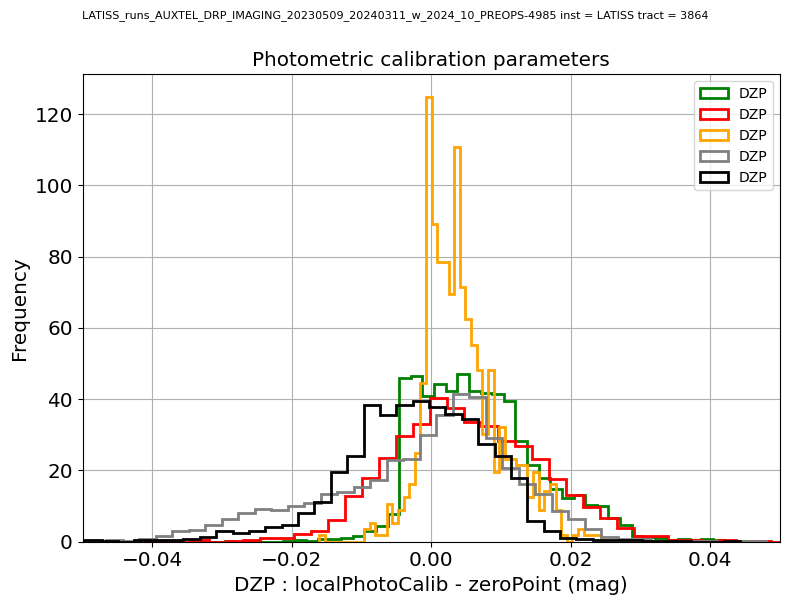

In [63]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
std = dataJoined_subset_g["DZP"].std()*1000
label = f"g,  sig = {std:.2f} mmag"
print(label)
dataJoined_subset_g["DZP"].plot.hist(bins=50,histtype="step",density=True,ax=ax,color="g",lw=2,legend=label)
std = dataJoined_subset_r["DZP"].std()*1000
label = f"r,  sig = {std:.2f} mmag"
print(label)
dataJoined_subset_r["DZP"].plot.hist(bins=50,histtype="step",density=True,ax=ax,color="r",lw=2,legend=label)
std = dataJoined_subset_i["DZP"].std()*1000
label = f"i,  sig = {std:.2f} mmag"
print(label)
dataJoined_subset_i["DZP"].plot.hist(bins=50,histtype="step",density=True,ax=ax,color="orange",lw=2,legend=label)
std = dataJoined_subset_z["DZP"].std()*1000
label = f"z,  sig = {std:.2f} mmag"
print(label)
dataJoined_subset_z["DZP"].plot.hist(bins=50,histtype="step",density=True,ax=ax,color="grey",lw=2,legend=label)
std = dataJoined_subset_y["DZP"].std()*1000
label = f"y,  sig = {std:.2f} mmag"
print(label)
dataJoined_subset_y["DZP"].plot.hist(bins=50,histtype="step",density=True,ax=ax,color="k",lw=2,legend=label)
ax.set_xlabel("DZP : localPhotoCalib - zeroPoint (mag)")
ax.set_xlim(-0.05,0.05)
ax.grid()
ax.legend()
ax.set_title("Photometric calibration parameters")
plt.suptitle(suptitle,y=1.0,fontsize=8)
plt.tight_layout()

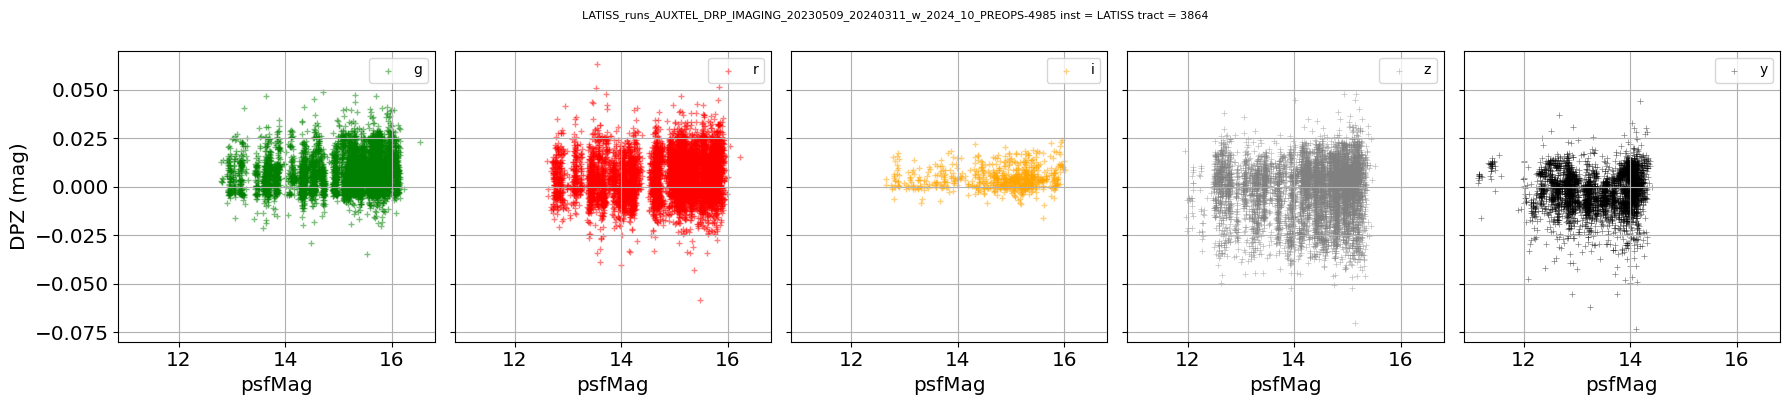

In [64]:
fig,axs = plt.subplots(1,5,figsize=(18,4),sharex=True,sharey=True)
ax1,ax2,ax3,ax4,ax5 =axs
dataJoined_subset_g.plot.scatter(x="psfMag",y="DZP",ax=ax1,color="g",marker="+",lw=1,label="g",grid=True,alpha=0.5)
dataJoined_subset_r.plot.scatter(x="psfMag",y="DZP",ax=ax2,color="r",marker="+",lw=1,label="r",grid=True,alpha=0.5)
dataJoined_subset_i.plot.scatter(x="psfMag",y="DZP",ax=ax3,color="orange",marker="+",lw=1,label="i",grid=True,alpha=0.5)
dataJoined_subset_z.plot.scatter(x="psfMag",y="DZP",ax=ax4,color="grey",marker="+",lw=0.5,label="z",grid=True,alpha=0.5)
dataJoined_subset_y.plot.scatter(x="psfMag",y="DZP",ax=ax5,color="k",marker="+",lw=0.5,label="y",grid=True,alpha=0.5)
ax1.set_ylabel("DPZ (mag)")
plt.suptitle(suptitle,y=1.0,fontsize=8)
plt.tight_layout()

### scatter plot on psf Flux vs aperture flux

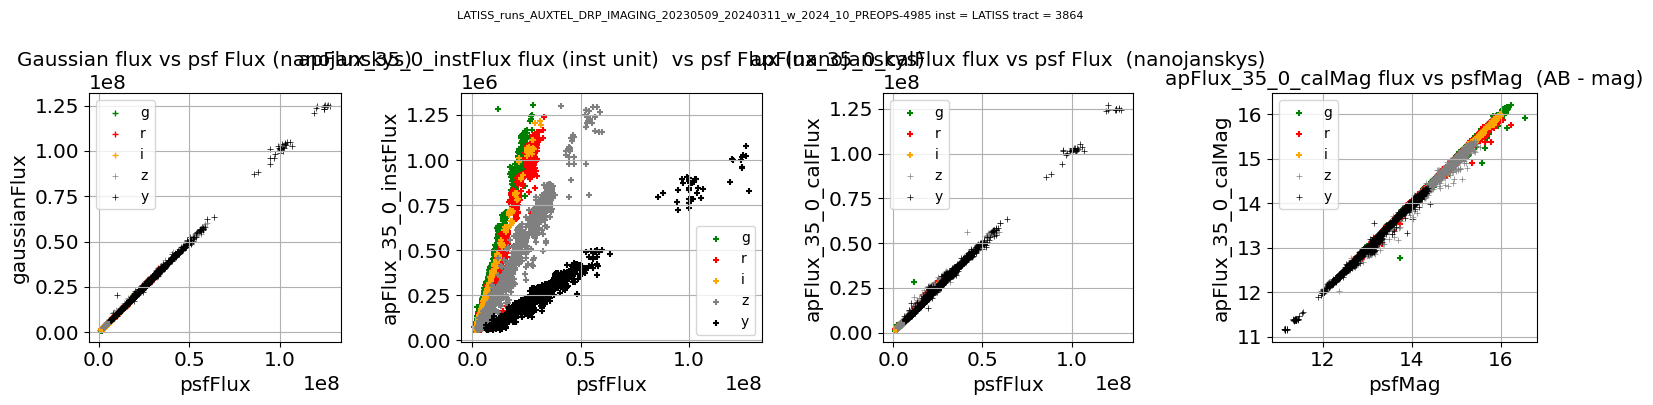

In [65]:
fig,axs = plt.subplots(1,4,figsize=(16,4))
ax=axs[0]
dataJoined_subset_g.plot.scatter(x="psfFlux",y="gaussianFlux",ax=ax,color="g",marker="+",lw=1,label="g")
dataJoined_subset_r.plot.scatter(x="psfFlux",y="gaussianFlux",ax=ax,color="r",marker="+",lw=1,label="r")
dataJoined_subset_i.plot.scatter(x="psfFlux",y="gaussianFlux",ax=ax,color="orange",marker="+",lw=1,label="i")
dataJoined_subset_z.plot.scatter(x="psfFlux",y="gaussianFlux",ax=ax,color="grey",marker="+",lw=0.5,label="z")
dataJoined_subset_y.plot.scatter(x="psfFlux",y="gaussianFlux",ax=ax,color="k",marker="+",lw=0.5,label="y")
ax.set_aspect("equal")
#ax.set_xlim(0.,0.6e8)
#ax.set_ylim(0.,0.6e8)
ax.set_title("Gaussian flux vs psf Flux (nanojanskys)")
ax.grid()

ax=axs[1]
dataJoined_subset_g.plot.scatter(x="psfFlux",y=calibFluxStr,ax=ax,color="g",marker="+",label="g")
dataJoined_subset_r.plot.scatter(x="psfFlux",y=calibFluxStr,ax=ax,color="r",marker="+",label="r")
dataJoined_subset_i.plot.scatter(x="psfFlux",y=calibFluxStr,ax=ax,color="orange",marker="+",label="i")
dataJoined_subset_z.plot.scatter(x="psfFlux",y=calibFluxStr,ax=ax,color="grey",marker="+",label="z")
dataJoined_subset_y.plot.scatter(x="psfFlux",y=calibFluxStr,ax=ax,color="k",marker="+",label="y")
ax.set_aspect("auto")
ax.set_title(f"{calibFluxStr} flux (inst unit)  vs psf Flux (nanojanskys)")
ax.grid()

ax=axs[2]
dataJoined_subset_g.plot.scatter(x="psfFlux",y=calibFluxCalStr,ax=ax,color="g",marker="+",label="g")
dataJoined_subset_r.plot.scatter(x="psfFlux",y=calibFluxCalStr,ax=ax,color="r",marker="+",label="r")
dataJoined_subset_i.plot.scatter(x="psfFlux",y=calibFluxCalStr,ax=ax,color="orange",marker="+",label="i")
dataJoined_subset_z.plot.scatter(x="psfFlux",y=calibFluxCalStr,ax=ax,color="grey",marker="+",lw=0.5,label="z")
dataJoined_subset_y.plot.scatter(x="psfFlux",y=calibFluxCalStr,ax=ax,color="k",marker="+",lw=0.5,label="y")
ax.set_aspect("equal")
#ax.set_xlim(0.,0.6e8)
#ax.set_ylim(0.,0.6e8)
ax.set_title(f"{calibFluxCalStr} flux vs psf Flux  (nanojanskys)")
ax.grid()

ax=axs[3]
dataJoined_subset_g.plot.scatter(x="psfMag",y=calibFluxCalMagStr,ax=ax,color="g",marker="+",label="g")
dataJoined_subset_r.plot.scatter(x="psfMag",y=calibFluxCalMagStr,ax=ax,color="r",marker="+",label="r")
dataJoined_subset_i.plot.scatter(x="psfMag",y=calibFluxCalMagStr,ax=ax,color="orange",marker="+",label="i")
dataJoined_subset_z.plot.scatter(x="psfMag",y=calibFluxCalMagStr,ax=ax,color="grey",marker="+",lw=0.5,label="z")
dataJoined_subset_y.plot.scatter(x="psfMag",y=calibFluxCalMagStr,ax=ax,color="k",marker="+",lw=0.5,label="y")
ax.set_aspect("equal")
#ax.set_xlim(0.,0.6e8)
#ax.set_ylim(0.,0.6e8)
ax.set_title(f"{calibFluxCalMagStr} flux vs psfMag  (AB - mag)")
ax.grid()


plt.suptitle(suptitle,y=1.0,fontsize=8)
plt.tight_layout()

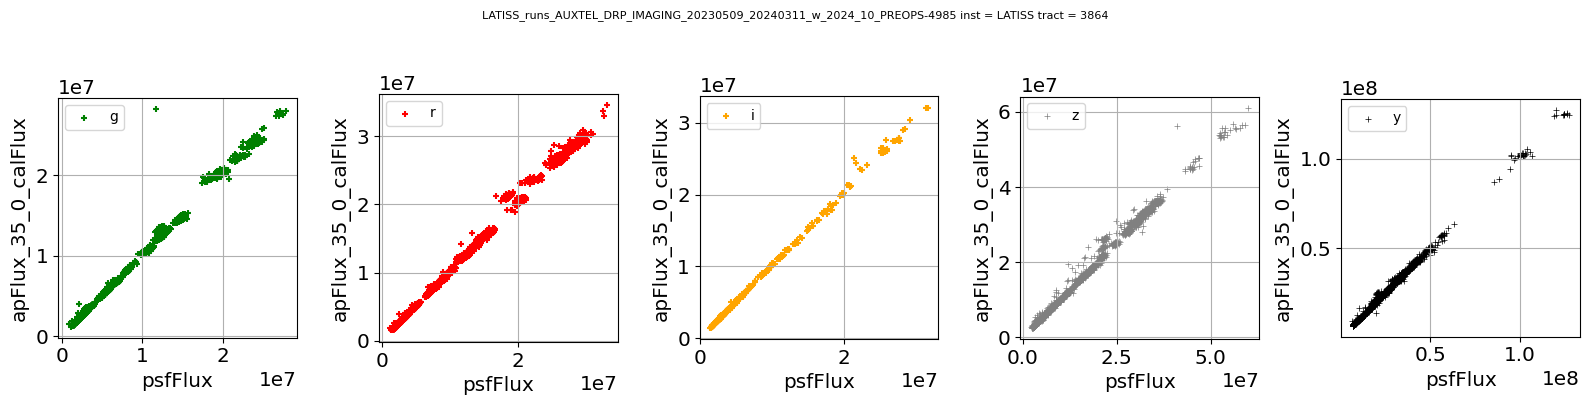

In [66]:
fig,axs = plt.subplots(1,5,figsize=(16,4))
ax=axs[0]
dataJoined_subset_g.plot.scatter(x="psfFlux",y=calibFluxCalStr,ax=ax,color="g",marker="+",label="g",grid=True)
ax.set_aspect('equal')
ax=axs[1]
dataJoined_subset_r.plot.scatter(x="psfFlux",y=calibFluxCalStr,ax=ax,color="r",marker="+",label="r",grid=True)
ax.set_aspect('equal')
ax=axs[2]
dataJoined_subset_i.plot.scatter(x="psfFlux",y=calibFluxCalStr ,ax=ax,color="orange",marker="+",label="i",grid=True)
ax.set_aspect('equal')
ax=axs[3]
dataJoined_subset_z.plot.scatter(x="psfFlux",y=calibFluxCalStr ,ax=ax,color="grey",marker="+",lw=0.5,label="z",grid=True)
ax.set_aspect('equal')
ax=axs[4]
dataJoined_subset_y.plot.scatter(x="psfFlux",y=calibFluxCalStr,ax=ax,color="k",marker="+",lw=0.5,label="y",grid=True)
ax.set_aspect('equal')
plt.suptitle(suptitle,y=1.0,fontsize=8)
plt.tight_layout()

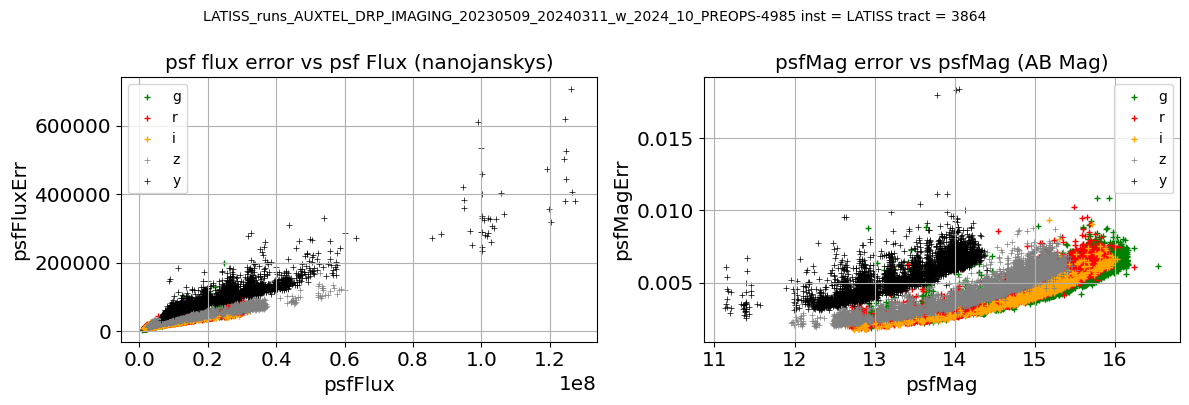

In [67]:
fig,axs = plt.subplots(1,2,figsize=(12,4))
ax=axs[0]
dataJoined_subset_g.plot.scatter(x="psfFlux",y="psfFluxErr",ax=ax,color="g",marker="+",lw=1,label="g")
dataJoined_subset_r.plot.scatter(x="psfFlux",y="psfFluxErr",ax=ax,color="r",marker="+",lw=1,label="r")
dataJoined_subset_i.plot.scatter(x="psfFlux",y="psfFluxErr",ax=ax,color="orange",marker="+",lw=1,label="i")
dataJoined_subset_z.plot.scatter(x="psfFlux",y="psfFluxErr",ax=ax,color="grey",marker="+",lw=0.5,label="z")
dataJoined_subset_y.plot.scatter(x="psfFlux",y="psfFluxErr",ax=ax,color="k",marker="+",lw=0.5,label="y")
ax.set_aspect("auto")

ax.set_title("psf flux error vs psf Flux (nanojanskys)")
ax.grid()

ax=axs[1]
dataJoined_subset_g.plot.scatter(x="psfMag",y="psfMagErr",ax=ax,color="g",marker="+",lw=1,label="g")
dataJoined_subset_r.plot.scatter(x="psfMag",y="psfMagErr",ax=ax,color="r",marker="+",lw=1,label="r")
dataJoined_subset_i.plot.scatter(x="psfMag",y="psfMagErr",ax=ax,color="orange",marker="+",lw=1,label="i")
dataJoined_subset_z.plot.scatter(x="psfMag",y="psfMagErr",ax=ax,color="grey",marker="+",lw=0.5,label="z")
dataJoined_subset_y.plot.scatter(x="psfMag",y="psfMagErr",ax=ax,color="k",marker="+",lw=0.5,label="y")
ax.set_aspect("auto")

ax.set_title("psfMag error vs psfMag (AB Mag)")
ax.grid()

plt.suptitle(suptitle,y=1.0,fontsize=10)
plt.tight_layout()

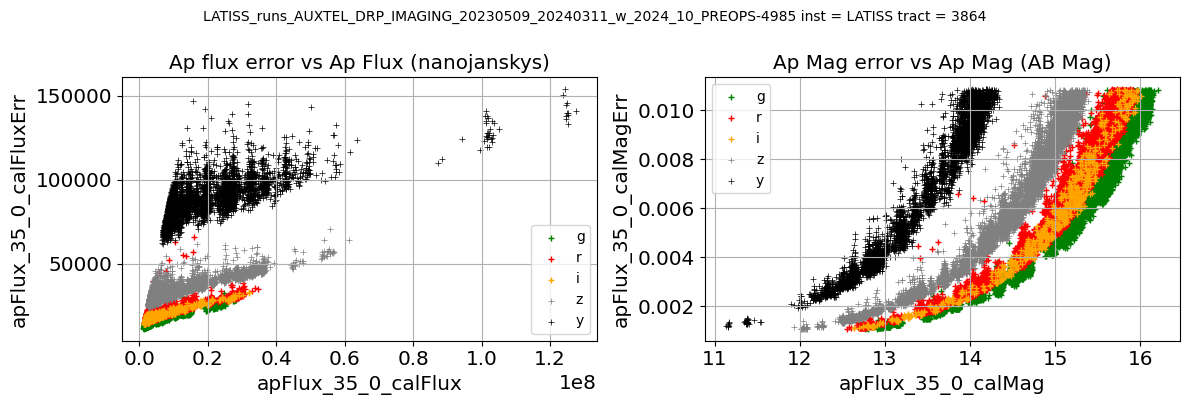

In [68]:
fig,axs = plt.subplots(1,2,figsize=(12,4))
ax=axs[0]
dataJoined_subset_g.plot.scatter(x=calibFluxCalStr,y=calibFluxCalErrStr,ax=ax,color="g",marker="+",lw=1,label="g")
dataJoined_subset_r.plot.scatter(x=calibFluxCalStr,y=calibFluxCalErrStr,ax=ax,color="r",marker="+",lw=1,label="r")
dataJoined_subset_i.plot.scatter(x=calibFluxCalStr,y=calibFluxCalErrStr,ax=ax,color="orange",marker="+",lw=1,label="i")
dataJoined_subset_z.plot.scatter(x=calibFluxCalStr,y=calibFluxCalErrStr,ax=ax,color="grey",marker="+",lw=0.5,label="z")
dataJoined_subset_y.plot.scatter(x=calibFluxCalStr,y=calibFluxCalErrStr,ax=ax,color="k",marker="+",lw=0.5,label="y")
ax.set_aspect("auto")

ax.set_title("Ap flux error vs Ap Flux (nanojanskys)")
ax.grid()

ax=axs[1]
dataJoined_subset_g.plot.scatter(x=calibFluxCalMagStr,y=calibFluxCalMagErrStr,ax=ax,color="g",marker="+",lw=1,label="g")
dataJoined_subset_r.plot.scatter(x=calibFluxCalMagStr,y=calibFluxCalMagErrStr,ax=ax,color="r",marker="+",lw=1,label="r")
dataJoined_subset_i.plot.scatter(x=calibFluxCalMagStr,y=calibFluxCalMagErrStr,ax=ax,color="orange",marker="+",lw=1,label="i")
dataJoined_subset_z.plot.scatter(x=calibFluxCalMagStr,y=calibFluxCalMagErrStr,ax=ax,color="grey",marker="+",lw=0.5,label="z")
dataJoined_subset_y.plot.scatter(x=calibFluxCalMagStr,y=calibFluxCalMagErrStr,ax=ax,color="k",marker="+",lw=0.5,label="y")
ax.set_aspect("auto")

ax.set_title("Ap Mag error vs Ap Mag (AB Mag)")
ax.grid()

plt.suptitle(suptitle,y=1.0,fontsize=10)
plt.tight_layout()

## Statistics on Light Curves

- want number of source per object

In [69]:
#my_list = list(dataJoined.columns)
#for name in my_list:
#    print(name)

#### Compute pandas series with multi-label or series per color 

In [70]:
count_source_visit = dataJoined_subset.groupby(by=["obj_index","band"]).count()["visit"]
size_source_visit = dataJoined_subset.groupby(by=["obj_index","band"]).size()
count_source_visit_g = dataJoined_subset_g.groupby(by=["obj_index"]).count()["sourceId"]
count_source_visit_r = dataJoined_subset_r.groupby(by=["obj_index"]).count()["sourceId"]
count_source_visit_i = dataJoined_subset_i.groupby(by=["obj_index"]).count()["sourceId"]
count_source_visit_z = dataJoined_subset_z.groupby(by=["obj_index"]).count()["sourceId"]
count_source_visit_y = dataJoined_subset_y.groupby(by=["obj_index"]).count()["sourceId"]
size_source_visit_g = dataJoined_subset_g.groupby(by=["obj_index"]).size()
size_source_visit_r = dataJoined_subset_r.groupby(by=["obj_index"]).size()
size_source_visit_i = dataJoined_subset_i.groupby(by=["obj_index"]).size()
size_source_visit_z = dataJoined_subset_z.groupby(by=["obj_index"]).size()
size_source_visit_y = dataJoined_subset_y.groupby(by=["obj_index"]).size()

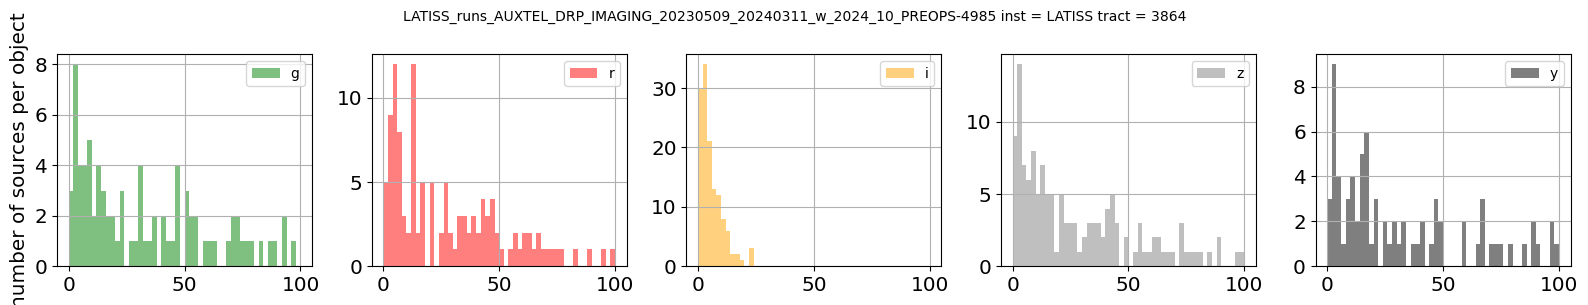

In [71]:
fig,axs = plt.subplots(1,5,figsize=(16,3))
ax=axs[0]
size_source_visit_g.hist(bins=50,range=(0,100.),ax=ax,facecolor="g",alpha=0.5,label="g")
ax.legend()
ax.set_ylabel("number of sources per object")
ax=axs[1]
size_source_visit_r.hist(bins=50,range=(0,100.),ax=ax,facecolor="r",alpha=0.5,label="r")
ax.legend()
ax=axs[2]
size_source_visit_i.hist(bins=50,range=(0,100.),ax=ax,facecolor="orange",alpha=0.5,label="i")
ax.legend()
ax=axs[3]
size_source_visit_z.hist(bins=50,range=(0,100.),ax=ax,facecolor="grey",alpha=0.5,label="z")
ax.legend()
ax=axs[4]
size_source_visit_y.hist(bins=50,range=(0,100.),ax=ax,facecolor="k",alpha=0.5,label="y")
ax.legend()


plt.suptitle(suptitle,y=1.0,fontsize=10)
plt.tight_layout()

In [72]:
#count_source_visit[3,"r"]

### Filtering the object using pandas series and dataframe

#### Unstacking a multi-label pandas series into a dataframe

In [73]:
NMIN = 10. # minimum number of visit in Y band
NBANDMIN = 3 # nimimum number of bands

In [74]:
size_source_visit 

obj_index  band
15         g        72
           i        23
           r       231
           z       198
21         i        22
                  ... 
1270       g        74
1271       g        53
1286       y        26
1287       y        11
1289       y         3
Length: 633, dtype: int64

In [75]:
size_source_visit_unstacked = size_source_visit.unstack()
size_source_visit_unstacked 

band,g,i,r,y,z
obj_index,,,,,
15,72.0,23.0,231.0,NaN,198.0
21,NaN,22.0,NaN,NaN,203.0
23,NaN,22.0,115.0,NaN,58.0
48,NaN,9.0,NaN,NaN,NaN
50,32.0,18.0,193.0,NaN,130.0
...,...,...,...,...,...
1270,74.0,NaN,NaN,NaN,NaN
1271,53.0,NaN,NaN,NaN,NaN
1286,NaN,NaN,NaN,26.0,NaN


#### Apply the selection on the pandas series

In [76]:
cut_on_size_in_bands =  (size_source_visit_unstacked.g>= NMIN) & (size_source_visit_unstacked.r>= NMIN) & (size_source_visit_unstacked.z>= NMIN ) &  (size_source_visit_unstacked.y>= NMIN )

size_source_visit_unstacked = size_source_visit_unstacked[cut_on_size_in_bands ] 
size_source_visit_unstacked

band,g,i,r,y,z
obj_index,,,,,
101,152.0,13.0,110.0,96.0,120.0
106,134.0,13.0,121.0,115.0,73.0
131,134.0,11.0,151.0,117.0,157.0
132,169.0,11.0,177.0,154.0,160.0
156,146.0,10.0,125.0,110.0,97.0
167,68.0,9.0,57.0,46.0,49.0
240,114.0,7.0,116.0,150.0,113.0
256,160.0,7.0,163.0,125.0,131.0
265,82.0,7.0,88.0,90.0,77.0


In [77]:
len(size_source_visit_unstacked)

30

#### Dropping the object not having a visit in all bands on the pandas dataframe from unstacked series

In [83]:
#size_source_visit_selected =size_source_visit_unstacked.dropna(axis=0,how='any') 
size_source_visit_selected =size_source_visit_unstacked
size_source_visit_selected

band,g,i,r,y,z
obj_index,,,,,
101,152.0,13.0,110.0,96.0,120.0
106,134.0,13.0,121.0,115.0,73.0
131,134.0,11.0,151.0,117.0,157.0
132,169.0,11.0,177.0,154.0,160.0
156,146.0,10.0,125.0,110.0,97.0
167,68.0,9.0,57.0,46.0,49.0
240,114.0,7.0,116.0,150.0,113.0
256,160.0,7.0,163.0,125.0,131.0
265,82.0,7.0,88.0,90.0,77.0


#### Restack the pandas dataframe into a pandas series with multi-label

In [84]:
ser_size_source_visit_selected = size_source_visit_selected.stack()
ser_size_source_visit_selected 

obj_index  band
101        g       152.0
           i        13.0
           r       110.0
           y        96.0
           z       120.0
                   ...  
925        z        31.0
948        g        43.0
           r        32.0
           y        33.0
           z        21.0
Length: 146, dtype: float64

#### Extract the list of selected objects from the pandas dataframe (from unstacked series)

In [85]:
selected_objects_indexes = list(size_source_visit_selected.index)
print("Nobj = ",len(selected_objects_indexes),"::",selected_objects_indexes )

Nobj =  30 :: [101, 106, 131, 132, 156, 167, 240, 256, 265, 333, 426, 442, 466, 470, 488, 514, 548, 549, 564, 570, 613, 617, 637, 647, 768, 851, 911, 917, 925, 948]


In [ ]:
#ser_size_source_visit_selected.keys() 

#### Loop on keys multi-label in pandas series

In [ ]:
#for name,group in dataJoined_subset.groupby(by=["obj_index","band"]):
#    print("name = ",name)
#    print("group = ",group["visitId"])

In [ ]:
#for (idx,band),val in count_source_visit:
#    print(idx,band,val)

### Plot the SED with psf Flux or 

- choose which type of photometry apFlux_35_0_calMag or psfMag

In [ ]:
FLAG_PSFMAG = True

In [ ]:
df_obj_sed = pd.DataFrame(columns=['idx_obj', 'ra', 'dec','magG', 'magR','magI','magZ','magY'])

icnt =0
for idx_obj_sel in selected_objects_indexes:
#for idx_obj_sel in [120]:
    cut_sel_object = dataJoined_subset.obj_index == idx_obj_sel 
    isolatedStarSources_sel = dataJoined_subset[cut_sel_object] 

    isolatedStarSources_sel_g = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "g"]
    isolatedStarSources_sel_r = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "r"]
    isolatedStarSources_sel_i = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "i"]
    isolatedStarSources_sel_z = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "z"]
    isolatedStarSources_sel_y = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "y"]

    ra = isolatedStarSources_sel_g['ra'].mean()
    dec = isolatedStarSources_sel_g['dec'].mean()

    if FLAG_PSFMAG:
        df_obj_sed.loc[icnt] = [idx_obj_sel,ra,dec,
                             isolatedStarSources_sel_g['psfMag'].median(),
                             isolatedStarSources_sel_r['psfMag'].median(),   
                             isolatedStarSources_sel_i['psfMag'].median(),   
                             isolatedStarSources_sel_z['psfMag'].median(),
                             isolatedStarSources_sel_y['psfMag'].median()]
    else:
        df_obj_sed.loc[icnt] = [idx_obj_sel,ra,dec,
                             isolatedStarSources_sel_g[calibFluxCalMagStr].median(),
                             isolatedStarSources_sel_r[calibFluxCalMagStr].median(),   
                             isolatedStarSources_sel_i[calibFluxCalMagStr].median(),   
                             isolatedStarSources_sel_z[calibFluxCalMagStr].median(),
                             isolatedStarSources_sel_y[calibFluxCalMagStr].median()]

    icnt +=1

In [ ]:


icnt =0
for idx_obj_sel in selected_objects_indexes:
#for idx_obj_sel in [120]:
    cut_sel_object = dataJoined_subset.obj_index == idx_obj_sel 
    isolatedStarSources_sel = dataJoined_subset[cut_sel_object] 

    isolatedStarSources_sel_g = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "g"]
    isolatedStarSources_sel_r = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "r"]
    isolatedStarSources_sel_i = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "i"]
    isolatedStarSources_sel_z = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "z"]
    isolatedStarSources_sel_y = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "y"]

    ra = isolatedStarSources_sel_g['ra'].mean()
    dec = isolatedStarSources_sel_g['dec'].mean()

    icnt +=1

    fig,axes = plt.subplots(1,5,figsize=(10,3))
    axs= axes.flatten()
    if FLAG_PSFMAG:
        for idx,ax in enumerate(axs):
            if idx==0:
                print(len(isolatedStarSources_sel_g["psfFlux"]))
                isolatedStarSources_sel_g["psfFlux"].hist(bins=100,facecolor="g",ax=ax, orientation="horizontal")
                #isolatedStarSources_sel_g["psfFlux"].hist(bins=100,facecolor="g",ax=ax)
                ax.legend("g")
                ax.set_ylabel("psfFlux (nanoJansky)")
            elif idx==1:
                isolatedStarSources_sel_r["psfFlux"].hist(bins=40,facecolor="r",ax=ax, orientation="horizontal")
                ax.legend("r")
            elif idx==2:
                isolatedStarSources_sel_i["psfFlux"].hist(bins=40,facecolor="orange",ax=ax, orientation="horizontal")
                ax.legend("z")
            elif idx==3:
                isolatedStarSources_sel_z["psfFlux"].hist(bins=40,facecolor="grey",ax=ax, orientation="horizontal")
                ax.legend("z")
            elif idx==4:
                isolatedStarSources_sel_y["psfFlux"].hist(bins=40,facecolor="k",ax=ax, orientation="horizontal")
                ax.legend("y")
    else:
        for idx,ax in enumerate(axs):
            if idx==0:
                print(len(isolatedStarSources_sel_g[calibFluxCalStr]))
                isolatedStarSources_sel_g[calibFluxCalMagStr].hist(bins=100,facecolor="g",ax=ax, orientation="horizontal")
                #isolatedStarSources_sel_g["psfFlux"].hist(bins=100,facecolor="g",ax=ax)
                ax.legend("g")
                ax.set_ylabel("Ap Flux (nanoJansky)")
            elif idx==1:
                isolatedStarSources_sel_r[calibFluxCalStr].hist(bins=40,facecolor="r",ax=ax, orientation="horizontal")
                ax.legend("r")
            elif idx==2:
                isolatedStarSources_sel_i[calibFluxCalStr].hist(bins=40,facecolor="orange",ax=ax, orientation="horizontal")
                ax.legend("z")
            elif idx==3:
                isolatedStarSources_sel_z[calibFluxCalStr].hist(bins=40,facecolor="grey",ax=ax, orientation="horizontal")
                ax.legend("z")
            elif idx==4:
                isolatedStarSources_sel_y[calibFluxCalStr].hist(bins=40,facecolor="k",ax=ax, orientation="horizontal")
                ax.legend("y")

    
    plt.tight_layout(h_pad=0)  
    title =f"object {idx_obj_sel}"
    #filename = f"sed_color_flux_obj_{idx_obj_sel}.png"
    plt.suptitle(title,y=1.000)
    #plt.savefig(filename)
    plt.show()

    if icnt> 10:
        break
plt.suptitle(suptitle,y=1.0,fontsize=10)

In [ ]:
icnt =0
for idx_obj_sel in selected_objects_indexes:
#for idx_obj_sel in [120]:
    cut_sel_object = dataJoined_subset.obj_index == idx_obj_sel 
    isolatedStarSources_sel = dataJoined_subset[cut_sel_object] 

    isolatedStarSources_sel_g = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "g"]
    isolatedStarSources_sel_r = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "r"]
    isolatedStarSources_sel_i = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "i"]
    isolatedStarSources_sel_z = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "z"]
    isolatedStarSources_sel_y = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "y"]

    ra = isolatedStarSources_sel_g['ra'].mean()
    dec = isolatedStarSources_sel_g['dec'].mean()

    icnt +=1

    fig,axes = plt.subplots(1,5,figsize=(10,3))
    axs= axes.flatten()


    if FLAG_PSFMAG:
        for idx,ax in enumerate(axs):
            if idx==0:
                isolatedStarSources_sel_g["psfMag"].hist(bins=100,facecolor="g",ax=ax, orientation="horizontal")
                #isolatedStarSources_sel_g["psfFlux"].hist(bins=100,facecolor="g",ax=ax)
                ax.legend("g")
                ax.set_ylabel("psfMag (AB)")
            elif idx==1:
                isolatedStarSources_sel_r["psfMag"].hist(bins=40,facecolor="r",ax=ax, orientation="horizontal")
                ax.legend("r")
            elif idx==2:
                isolatedStarSources_sel_i["psfMag"].hist(bins=40,facecolor="orange",ax=ax, orientation="horizontal")
                ax.legend("i")
            elif idx==3:
                isolatedStarSources_sel_z["psfMag"].hist(bins=40,facecolor="grey",ax=ax, orientation="horizontal")
                ax.legend("z")
            elif idx==4:
                isolatedStarSources_sel_y["psfMag"].hist(bins=40,facecolor="k",ax=ax, orientation="horizontal")
                ax.legend("y")

    else:
         for idx,ax in enumerate(axs):
            if idx==0:
                isolatedStarSources_sel_g[calibFluxCalMagStr].hist(bins=100,facecolor="g",ax=ax, orientation="horizontal")
                #isolatedStarSources_sel_g["psfFlux"].hist(bins=100,facecolor="g",ax=ax)
                ax.legend("g")
                ax.set_ylabel("Ap Mag (AB)")
            elif idx==1:
                isolatedStarSources_sel_r[calibFluxCalMagStr].hist(bins=40,facecolor="r",ax=ax, orientation="horizontal")
                ax.legend("r")
            elif idx==2:
                isolatedStarSources_sel_i[calibFluxCalMagStr].hist(bins=40,facecolor="orange",ax=ax, orientation="horizontal")
                ax.legend("i")
            elif idx==3:
                isolatedStarSources_sel_z[calibFluxCalMagStr].hist(bins=40,facecolor="grey",ax=ax, orientation="horizontal")
                ax.legend("z")
            elif idx==4:
                isolatedStarSources_sel_y[calibFluxCalMagStr].hist(bins=40,facecolor="k",ax=ax, orientation="horizontal")
                ax.legend("y")
                

    plt.tight_layout(h_pad=0)  
    title =f"object {idx_obj_sel}"
    #filename = f"sed_color_flux_obj_{idx_obj_sel}.png"
    plt.suptitle(title,y=1.000)
    #plt.savefig(filename)
    plt.show()

    if icnt> 10:
        break
plt.suptitle(suptitle,y=1.0,fontsize=10)

In [ ]:
# define the sigmaclip algo
sigclip = SigmaClip(sigma=3, maxiters=None, cenfunc='mean')


df_obj_sed = pd.DataFrame(columns=['idx_obj', 'ra', 'dec','magG', 'magR','magI','magZ','magY','smagG', 'smagR','smagI','smagZ','smagY'])

icnt =0
for idx_obj_sel in selected_objects_indexes:
#for idx_obj_sel in [120]:
    cut_sel_object = dataJoined_subset.obj_index == idx_obj_sel 
    isolatedStarSources_sel = dataJoined_subset[cut_sel_object] 

    isolatedStarSources_sel_g = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "g"]
    isolatedStarSources_sel_r = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "r"]
    isolatedStarSources_sel_i = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "i"]
    isolatedStarSources_sel_z = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "z"]
    isolatedStarSources_sel_y = isolatedStarSources_sel[isolatedStarSources_sel["band"] == "y"]

    if FLAG_PSFMAG:
        sample_g = isolatedStarSources_sel_g['psfMag'].values
        sample_r = isolatedStarSources_sel_r['psfMag'].values
        sample_i = isolatedStarSources_sel_i['psfMag'].values
        sample_z = isolatedStarSources_sel_z['psfMag'].values
        sample_y = isolatedStarSources_sel_y['psfMag'].values
    else:
        sample_g = isolatedStarSources_sel_g[calibFluxCalMagStr].values
        sample_r = isolatedStarSources_sel_r[calibFluxCalMagStr].values
        sample_i = isolatedStarSources_sel_i[calibFluxCalMagStr].values
        sample_z = isolatedStarSources_sel_z[calibFluxCalMagStr].values
        sample_y = isolatedStarSources_sel_y[calibFluxCalMagStr].values
        
 
    
    sample_g = sigclip(sample_g, masked=False, copy=False)
    sample_r = sigclip(sample_r, masked=False, copy=False)
    sample_i = sigclip(sample_i, masked=False, copy=False)
    sample_z = sigclip(sample_z, masked=False, copy=False)
    sample_y = sigclip(sample_y, masked=False, copy=False)

    # sig gaussian estimation
    med_g = np.median(sample_g)
    med_r = np.median(sample_r)
    med_i = np.median(sample_i)
    med_z = np.median(sample_z)
    med_y = np.median(sample_y)
    
    sig_g = 0.7413*(np.percentile(sample_g,75.0) - np.percentile(sample_g,25.0))
    sig_r = 0.7413*(np.percentile(sample_r,75.0) - np.percentile(sample_r,25.0))
    sig_i = 0.7413*(np.percentile(sample_i,75.0) - np.percentile(sample_i,25.0))
    sig_z = 0.7413*(np.percentile(sample_z,75.0) - np.percentile(sample_z,25.0))
    sig_y = 0.7413*(np.percentile(sample_y,75.0) - np.percentile(sample_y,25.0))
    
    ra = isolatedStarSources_sel_g['ra'].mean()
    dec = isolatedStarSources_sel_g['dec'].mean()
    
    df_obj_sed.loc[icnt] = [idx_obj_sel,ra,dec,
                             #sample_g.mean(),sample_r.mean(),sample_i.mean(),0.,0.,
                             #sample_g.median(),sample_r.median(),sample_i.median(),0.,0.,
                             #sample_g.std(),sample_r.std(),sample_i.std(),0.,0.
                            med_g,med_r,med_i,med_z,med_y,
                            sig_g,sig_r,sig_i,sig_z,sig_y
                           ]

    icnt +=1

In [ ]:
dict_photores = {}
Flist = ["G","R","I","Z","Y"]
for f in Flist :
    label = f"smag{f}"
    samples = df_obj_sed[label].values
    smean = np.median(samples)
    smmag = smean*1000. 
    title = "{} = {:.2f} mmag".format(label,smmag)

    d = dict(sig=smean,title=title)
    dict_photores[f] = d

In [ ]:
dict_photores

In [ ]:
fig,axes = plt.subplots(1,5,figsize=(16,4),sharey=True)
axs= axes.flatten()
for idx,ax in enumerate(axs):
    f = Flist[idx]
    if idx==0:
           
            #isolatedStarSources_sel_g["psfMag"].hist(bins=100,facecolor="g",ax=ax, orientation="horizontal")
            df_obj_sed.plot.scatter( x="magG", y="smagG",marker= "+", color="g",ax=ax)
            ax.legend("g")
            ax.set_ylabel("sigma Mag (AB)")
            ax.grid()
            ax.axhline(dict_photores[f]['sig'],color="g",lw=3)
            ax.set_title(dict_photores[f]['title'])
   
    elif idx==1:
            df_obj_sed.plot.scatter( x="magR", y="smagR",marker= "+", color="r",ax=ax)
            ax.legend("r")
            ax.grid()
            ax.axhline(dict_photores[f]['sig'],color="r",lw=3)
            ax.set_title(dict_photores[f]['title'])
    elif idx==2:
            df_obj_sed.plot.scatter( x="magI", y="smagI",marker= "+", color="orange",ax=ax)
            ax.legend("i")   
            ax.grid()
            ax.axhline(dict_photores[f]['sig'],color="orange",lw=3)
            ax.set_title(dict_photores[f]['title'])
    elif idx==3:
            df_obj_sed.plot.scatter( x="magZ", y="smagZ",marker= "+", color="grey",ax=ax)
            ax.legend("z")
            ax.grid()
            ax.axhline(dict_photores[f]['sig'],color="grey")
            ax.set_title(dict_photores[f]['title'])
    elif idx==4:
            df_obj_sed.plot.scatter( x="magY", y="smagY",marker= "+", color="k",ax=ax)
            ax.legend("y")
            ax.grid()
            ax.axhline(dict_photores[f]['sig'],color="k")
            ax.set_title(dict_photores[f]['title'])
ax.set_ylim(0.,0.05)
plt.tight_layout(h_pad=0)  

#    plt.suptitle(title,y=1.000)
#    plt.savefig(filename)
plt.suptitle(suptitle,y=1.0,fontsize=10)
plt.show()

### add object color

In [ ]:
df_obj_sed["G_R"] = df_obj_sed["magG"] - df_obj_sed["magR"]
df_obj_sed["Z_Y"] = df_obj_sed["magZ"] - df_obj_sed["magI"]

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(10,6))

df_obj_sed.plot.scatter(x="G_R", y="smagR",marker= "o", color="g",ax=ax,label="sigR vs G-R")
df_obj_sed.plot.scatter(x="R_I", y="smagR",marker= "o", color="r",ax=ax,label="sigR vs R-I")
ax.set_xlabel("color (G-R, R-I)")
ax.set_ylabel("sigR (mag)")
ax.set_title("photometric repeatability vs color")
ax.grid()
ax.set_ylim(0.,0.02)
plt.suptitle(suptitle,y=1.0,fontsize=10)
plt.show()

In [ ]:
fig,axes = plt.subplots(1,5,figsize=(16,4),sharey=True)
axs= axes.flatten()
for idx,ax in enumerate(axs):
    f = Flist[idx]
    if idx==0:
           
            #isolatedStarSources_sel_g["psfMag"].hist(bins=100,facecolor="g",ax=ax, orientation="horizontal")
            df_obj_sed.hist("smagG",bins=30,range=(0,0.02), color="g",ax=ax)
            ax.legend("g")
            ax.set_xlabel("sigma Mag (AB)")
            ax.grid()
            ax.axvline(dict_photores[f]['sig'],color="g",ls=":")
            ax.set_title(dict_photores[f]['title'])
   
    elif idx==1:
            df_obj_sed.hist("smagR",bins=30,range=(0,0.02), color="r",ax=ax)
            ax.legend("r")
            ax.grid()
            ax.set_xlabel("sigma Mag (AB)")
            ax.axvline(dict_photores[f]['sig'],color="r",ls=":")
            ax.set_title(dict_photores[f]['title'])
    elif idx==2:
            df_obj_sed.hist("smagI",bins=30,range=(0,0.02), color="orange",ax=ax)
            ax.legend("i")   
            ax.grid()
            ax.axvline(dict_photores[f]['sig'],color="orange",ls=":")
            ax.set_title(dict_photores[f]['title'])
            ax.set_xlabel("sigma Mag (AB)")
    elif idx==3:
            df_obj_sed.hist("smagZ",bins=30,range=(0,0.02), color="grey",ax=ax)
            ax.legend("z")
            ax.grid()
            ax.axvline(dict_photores[f]['sig'],color="grey",ls=":")
            ax.set_title(dict_photores[f]['title'])
            ax.set_xlabel("sigma Mag (AB)")
    elif idx==4:
            df_obj_sed.hist("smagY",bins=30,range=(0,0.02), color="k",ax=ax)
            ax.legend("y")
            ax.grid()
            ax.axvline(dict_photores[f]['sig'],color="k",ls=":")
            ax.set_title(dict_photores[f]['title'])
            ax.set_xlabel("sigma Mag (AB)")
plt.tight_layout(h_pad=0)  

#    plt.suptitle(title,y=1.000)
#    plt.savefig(filename)
plt.suptitle(suptitle,y=1.0,fontsize=10)
plt.show()

### Cut on selected light-curves

In [ ]:
obj_ids_all = df_obj_sed.idx_obj.values.astype(int)

In [ ]:
cut_goods = (df_obj_sed["smagG"]<0.002) & (df_obj_sed["smagR"]<0.002)	& (df_obj_sed["smagI"]<0.002) 
cut_bads = (df_obj_sed["smagG"]>0.1) | (df_obj_sed["smagI"]>0.1) | (df_obj_sed["smagY"] > 0.1)

In [ ]:
df_obj_sed_goods = df_obj_sed[cut_goods]
df_obj_sed_bads = df_obj_sed[cut_bads]

In [ ]:
df_obj_sed_goods

In [ ]:
obj_ids_goods = df_obj_sed_goods.idx_obj.values.astype(int)
obj_ids_goods 

In [ ]:
obj_ids_bads = df_obj_sed_bads.idx_obj.values.astype(int)
obj_ids_bads 

In [ ]:
def plot_light_curves_from_objects(list_of_objids,obj_cat,src_cat,title="PhotometricRepeatab",all_bands_name=["g","r","i","z","y"],
                                  all_bands_color=["g","r","orange","grey","k"]):
    """
    parameters :
        list_of_objids : list of integers
        obj_cat : df_obj_sed 
        src_cat : dataJoined
    """
    nrows = len(list_of_objids)
    
    fig,axes = plt.subplots(nrows,1,figsize=(16,3*nrows),sharex=True)
    axs= axes.flatten()

    for idx,obj_id  in enumerate(list_of_objids):
        ax = axs[idx]
        cut = src_cat["obj_index"] == obj_id
        ax.set_title(f" object = {obj_id}")
        sources = src_cat[cut]
        for ib,band in enumerate(all_bands_name):
            sources_inband = sources[sources["band"] == band].sort_values(by="expMidptMjd")
            sources_inband.plot(x='expMidptMjd',y='psfMag',marker="+",ls=":",color= all_bands_color[ib],legend=band,ax=ax,grid=True)
        
        ax.set_ylabel( "psfMag" + " (mag)" ) 
        
    plt.suptitle(title+suptitle,y=1.0,fontsize=10)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_rel_light_curves_from_objects(list_of_objids,obj_cat,src_cat,title="PhotometricRepeatab",all_bands_name=["g","r","i","z","y"],
                                  all_bands_color=["g","r","orange","grey","k"]):
    """
    parameters :
        list_of_objids : list of integers
        obj_cat : df_obj_sed 
        src_cat : dataJoined
    """
    nrows = len(list_of_objids)
    
    fig,axes = plt.subplots(nrows,1,figsize=(16,3*nrows),sharex=True)
    axs= axes.flatten()

    for idx,obj_id  in enumerate(list_of_objids):
        ax = axs[idx]
        cut = src_cat["obj_index"] == obj_id
        ax.set_title(f" object = {obj_id}")
        sources = src_cat[cut]
        obj_cut = obj_cat.idx_obj ==  obj_id
        objectline =  obj_cat[obj_cut]
      
        for ib,band in enumerate(all_bands_name):
            tab_label = "mag"+band.upper()
            aver_mag =  objectline[tab_label].values
            N = len(aver_mag) 
          
            if N ==1:
                sources_inband = sources[sources["band"] == band].sort_values(by="expMidptMjd")
                sources_inband["psfMagRel"] =  sources_inband['psfMag'] -  aver_mag[0]
                #sources_inband["psfMagRel"] =  sources_inband['psfMag'] -  sources_inband['psfMag'].median()
                sources_inband.plot(x='expMidptMjd',y='psfMagRel',marker="+",ls=":",color= all_bands_color[ib],legend=band,ax=ax,grid=True)
        
        ax.set_ylabel( ax.get_ylabel() + " (mag)" ) 
    plt.suptitle(title+suptitle,y=1.0,fontsize=10)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_photomshift_vsquantity_from_objects(list_of_objids,obj_cat,src_cat,quantity,title="Photometric shift vs",all_bands_name=["g","r","i","z","y"],
                                  all_bands_color=["g","r","orange","grey","k"]):
    """
    parameters :
        list_of_objids : list of integers
        obj_cat : df_obj_sed 
        src_cat : dataJoined
        quantity : quantity to plot in the source catalog
    """
   
    
    fig,ax = plt.subplots(1,1,figsize=(8,6),sharex=True)
    
    # loop on objects
    for idx,obj_id  in enumerate(list_of_objids):

        #select those sources belonging to this objecy
        cut = src_cat["obj_index"] == obj_id
        sources = src_cat[cut]

        # get info for this object
        obj_cut = obj_cat.idx_obj ==  obj_id
        objectline =  obj_cat[obj_cut]

        # loop on bands
        for ib,band in enumerate(all_bands_name):
            tab_label = "mag"+band.upper()
            aver_mag =  objectline[tab_label].values
            N = len(aver_mag) 
          
            if N ==1:
                sources_inband = sources[sources["band"] == band].sort_values(by=quantity)
                sources_inband["psfMagRel"] =  sources_inband['psfMag'] -  aver_mag[0]
                #sources_inband["psfMagRel"] =  sources_inband['psfMag'] -  sources_inband['psfMag'].median()
                if idx==0:
                    sources_inband.plot.scatter(x=quantity,y='psfMagRel',marker="o",color= all_bands_color[ib],ax=ax,grid=True,label=band)
                else:
                    sources_inband.plot.scatter(x=quantity,y='psfMagRel',marker="o",color= all_bands_color[ib],ax=ax,grid=True)
        
    ax.set_ylabel( ax.get_ylabel() + " (mag)" ) 
    plt.suptitle(title + quantity + " "+suptitle,y=1.0,fontsize=10)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_photomshift_vsquantity_from_objects_v2(list_of_objids,obj_cat,src_cat,quantity,title="Photometric shift vs",all_bands_name=["g","r","i","z","y"],
                                  all_bands_color=["g","r","orange","grey","k"]):
    """
    parameters :
        list_of_objids : list of integers
        obj_cat : df_obj_sed 
        src_cat : dataJoined
        quantity : quantity to plot in the source catalog
    """
  
    
    fig,ax = plt.subplots(1,1,figsize=(8,6),sharex=True)
    

    for idx,obj_id  in enumerate(list_of_objids):
        cut = src_cat["obj_index"] == obj_id
      
        sources = src_cat[cut]
        obj_cut = obj_cat.idx_obj ==  obj_id
        objectline =  obj_cat[obj_cut]
      
        for ib,band in enumerate(all_bands_name):
            tab_label = "mag"+band.upper()
            aver_mag =  objectline[tab_label].values
            N = len(aver_mag) 
          
            if N ==1:
                sources_inband = sources[sources["band"] == band]
                sources_inband["psfMagRel"] =  sources_inband['psfMag'] -  aver_mag[0]
                #sources_inband["psfMagRel"] =  sources_inband['psfMag'] -  sources_inband['psfMag'].median()
                sources_inband[quantity] =  objectline[quantity]
                if idx==0:
                    sources_inband.plot.scatter(x=quantity,y='psfMagRel',marker="o",color= all_bands_color[ib],ax=ax,grid=True,label=band)
                else:
                    sources_inband.plot.scatter(x=quantity,y='psfMagRel',marker="o",color= all_bands_color[ib],ax=ax,grid=True)
        
    
    plt.suptitle(title + quantity + " "+suptitle,y=1.0,fontsize=10)
    plt.tight_layout()
    plt.show()

## Light curves for good objects

In [ ]:
#dataJoined

In [ ]:
plot_light_curves_from_objects(obj_ids_goods, df_obj_sed ,dataJoined)

In [ ]:
plot_rel_light_curves_from_objects(obj_ids_goods, df_obj_sed ,dataJoined)

# *********   END ***********************

In [ ]:
assert Falsecd

In [ ]:
#plot_photomshift_vsquantity_from_objects(obj_ids_all, df_obj_sed ,dataJoined,"airmass")

In [ ]:
#plot_photomshift_vsquantity_from_objects(obj_ids_all, df_obj_sed ,dataJoined,"seeing")

In [ ]:
#plot_photomshift_vsquantity_from_objects(obj_ids_all, df_obj_sed ,dataJoined,"DZP")

In [ ]:
#plot_photomshift_vsquantity_from_objects(obj_ids_all, df_obj_sed ,dataJoined,"DPZ")

In [ ]:
#plot_photomshift_vsquantity_from_objects_v2(obj_ids_all,df_obj_sed ,dataJoined,quantity="Z_Y",title="Photometric Shift vs",all_bands_name=["y"],
#                                  all_bands_color=["k"])

### Light curves for Goods

In [ ]:
#plot_light_curves_from_objects(obj_ids_goods, df_obj_sed ,dataJoined)

### Light curves for bads

In [ ]:
#plot_light_curves_from_objects(obj_ids_bads, df_obj_sed ,dataJoined)

In [ ]:
#plot_rel_light_curves_from_objects(obj_ids_goods, df_obj_sed ,dataJoined)

In [ ]:
#plot_rel_light_curves_from_objects(obj_ids_bads, df_obj_sed ,dataJoined)

In [ ]:
#plot_photombias_vsquantity_from_objects(obj_ids_all, df_obj_sed ,dataJoined,"airmass")

In [ ]:
#plot_photombias_vsquantity_from_objects(obj_ids_all, df_obj_sed ,dataJoined,"seeing")

## Find the list of visits associated with an object

In [ ]:
obj_index_sel  = obj_ids_all[0]  

In [ ]:
cut = dataJoined["obj_index"] == obj_index_sel 

In [ ]:
dataJoined_sel = dataJoined[cut]

In [ ]:
dataJoined_sel

In [ ]:
ra = dataJoined_sel["ra"].values
dec = dataJoined_sel["dec"].values

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(8,8))
ax.set_title(f"object = {obj_index_sel}")
dataJoined_sel[dataJoined_sel.band=="g"].plot.scatter(x="ra",y="dec",marker="+",color="g",ax=ax,grid=True,label="g")
dataJoined_sel[dataJoined_sel.band=="r"].plot.scatter(x="ra",y="dec",marker="+",color="r",ax=ax,grid=True,label="r")
dataJoined_sel[dataJoined_sel.band=="i"].plot.scatter(x="ra",y="dec",marker="+",color="orange",ax=ax,grid=True,label="i")
dataJoined_sel[dataJoined_sel.band=="z"].plot.scatter(x="ra",y="dec",marker="+",color="grey",ax=ax,grid=True,label="z")
dataJoined_sel[dataJoined_sel.band=="y"].plot.scatter(x="ra",y="dec",marker="+",color="k",ax=ax,grid=True,label="y")

ra_g = dataJoined_sel[dataJoined_sel.band=="g"]["ra"].mean()
dec_g = dataJoined_sel[dataJoined_sel.band=="g"]["dec"].mean()
ax.axvline(ra_g,color="g")
ax.axhline(dec_g,color="g")

plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.gca().set_aspect('equal')
plt.suptitle(suptitle)
plt.tight_layout()

In [ ]:
from lsst.geom import Angle 
import lsst
func_degToRad = lambda x : Angle(x,lsst.geom.degrees).asRadians()
func_degToArcsec = lambda x : Angle(x,lsst.geom.degrees).asArcseconds()

In [ ]:
fig,axs=plt.subplots(1,2,figsize=(8,4))
ax1,ax2 = axs
#ax.set_title(f"object = {obj_index_sel}")
for bandname,col  in zip(["g","r","i","z","y"],["g","r","orange","grey","k"]):
    
    angle_sep_deg = (dataJoined_sel[dataJoined_sel.band==bandname]["ra"] - dataJoined_sel[dataJoined_sel.band==bandname]["ra"].mean())
    angle_sep_arcsec = angle_sep_deg.apply(func_degToArcsec).values
    ax1.hist(angle_sep_arcsec,bins=50,range=(-0.05,0.05),histtype="step",color=col,density=True,label=bandname)
    ax1.set_xlabel("delta-ra (arcsec)")

    angle_sep_deg = (dataJoined_sel[dataJoined_sel.band==bandname]["dec"] - dataJoined_sel[dataJoined_sel.band==bandname]["dec"].mean())
    angle_sep_arcsec = angle_sep_deg.apply(func_degToArcsec).values
    ax2.hist(angle_sep_arcsec,bins=50,range=(-0.05,0.05),histtype="step",color=col,density=True,label=bandname)
    ax2.set_xlabel("delta-dec (arcsec)")


plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
#plt.gca().set_aspect('equal')
plt.suptitle(suptitle)
plt.tight_layout()

In [ ]:
dataJoined_sel[["visit","band"]]

In [ ]:
visit_id_band = dataJoined_sel[["visit","band"]].iloc[0]
visit_id = visit_id_band['visit']
band = visit_id_band['band']

In [ ]:
visit_id

In [ ]:
dataId = {'visit': visit_id, 'instrument':instrument , 'detector': 0}

In [ ]:
img = butler.get("calexp", dataId=dataId, collections=collection)
bkgd = butler.get('calexpBackground', **dataId,collections=collection)

wcs = img.getWcs()
bbox = img.getBBox()
corners_ra, corners_dec = get_corners_radec(wcs, bbox)
extent = [np.min(corners_ra),np.max(corners_ra),np.min(corners_dec),np.max(corners_dec)]


In [ ]:
all_id_obj = df_obj_sed.idx_obj.values.astype(int)
all_ra_obj = df_obj_sed["ra"].values 
all_dec_obj = df_obj_sed["dec"].values 

In [ ]:
#%matplotlib widget

# Display the image with a suitable scaling
med = np.median(img.image.array.flatten())
sigMad = 1.4826 * np.median(np.fabs(img.image.array.flatten() - med))
vmin = med - 3 * sigMad
vmax = med + 3 * sigMad

fig,axs = plt.subplots(2,1,figsize=(10,16))
ax = axs[0]
im=ax.imshow(img.image.array, origin="lower",vmin=vmin, vmax=vmax, cmap="Greys",extent=extent)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
the_title = f"Calexp : visit = {visit_id}, band = {band}"
ax.set_title(the_title)
ax.grid()
ax.set_aspect('equal')
ax.scatter(all_ra_obj,all_dec_obj,marker="o",color="y",s=200,facecolors='none', edgecolors='r')

for x, y, txt in np.broadcast(all_ra_obj, all_dec_obj, all_id_obj):
    ax.annotate(str(txt), (x, y),color="b")

plt.colorbar(im, cax=cax,ax=ax)


ax2 = axs[1]
im2=ax2.imshow(bkgd.getImage().array, origin="lower", cmap="Greys",extent=extent)
divider = make_axes_locatable(ax2)
cax2 = divider.append_axes("right", size="5%", pad=0.05)
the_title2 = f"Calexp_bkg : visit = {visit_id}, band = {band}"
ax2.set_title(the_title2)
ax2.grid()
ax2.set_aspect('equal')
plt.colorbar(im2, cax=cax2,ax=ax2)
ax2.scatter(all_ra_obj,all_dec_obj,marker="+",color="r",s=500)

plt.suptitle(suptitle)
plt.tight_layout()
plt.show()

In [ ]:
#diagramme magnitude Z vs couleur (Z-Y) et voir l’étalement de
#la séquence principale, et peut-être la branche des géantes rouges.

In [ ]:
Nobj = len(df_obj_sed)
import seaborn as sns
from matplotlib.colors import ListedColormap
color_palette = sns.color_palette("hls", Nobj)

In [ ]:
color_palette

In [ ]:
mpl_colors = ListedColormap(sns.color_palette(color_palette).as_hex())

In [ ]:
mpl_colors.colors

In [ ]:
df_obj_sed["Z-Y"] = df_obj_sed["magZ"] - df_obj_sed["magY"] 
df_obj_sed["G-R"] = df_obj_sed["magG"] - df_obj_sed["magR"] 

In [ ]:
fig,axs = plt.subplots(1,3,figsize=(14,4))

ax=axs[0]
df_obj_sed.plot.scatter(y="magR",x="G-R",ax=ax,color=mpl_colors.colors)
ax.invert_yaxis()


ax=axs[1]
df_obj_sed.plot.scatter(y="magZ",x="Z-Y",ax=ax,color=mpl_colors.colors)
ax.invert_yaxis()


ax=axs[2]
df_obj_sed.plot.scatter(y="Z-Y",x="G-R",ax=ax,color=mpl_colors.colors)
#ax.invert_yaxis()

plt.suptitle(suptitle + f"in tract {tract}")
plt.tight_layout()

In [ ]:
df_obj_sed.to_csv(f"isolated_source_objects_tract{tract}.csv")

In [ ]:
# STOP HERE FOR THE MOMENT
assert False

In [ ]:
count_source_visit.hist(x="obj_index")

In [ ]:
count_sources = dataJoined.groupby(by="obj_index").count()["psfFlux"]

In [ ]:
count_source.hist(bins=100,range=(0,100))

In [ ]:
assert False

## Plot the per object source 

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.set_title("{}\n{} {} (max visit: {})".format(collection, tract, band, max(dataJoined["visit"])), fontsize=8)
nBins = 16 if len(dataJoined) < 4000 else 100
histData = psfMagStdMmagAll
xLabelStr = "std(psfFlux - psfFluxMean) ({} mmag)".format(band)
medianPsfFluxStd = np.median(histData)
n, bins, patches = ax.hist(histData, bins=nBins, density=True, histtype="step", lw=2, label="data (N = {})".format(len(histData)))
ax.axvline(x=medianPsfFluxStd, color="gray", linestyle='--', linewidth=1, label="median: {:.2f}".format(medianPsfFluxStd))

ax.tick_params(labelsize=7)
ax.set_xlabel(xLabelStr, fontsize=9)
ax.set_ylabel("Normalized (PDF)".format(band), fontsize=9)

ax.legend(fontsize=8)
if doSaveFigs:
    filename = "{}psfFluxStdHist_{}_{}_{}".format(saveDir, tract, band, collectionStr)
    print("Saving file in: {}".format(filename))
    fig.savefig(filename, dpi=150)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.set_title("{}\n{} {} (max visit: {})".format(collection, tract, band, max(dataJoined["visit"])), fontsize=8)

medianRaStd = np.median(raStdMasAll)
n, bins, patches = ax.hist(raStdMasAll, bins=nBins, density=True, histtype="step", color="tab:blue", lw=2, label="RA (N = {})".format(len(raStdMasAll)))

medianDecStd = np.median(decStdMasAll)
n, bins, patches = ax.hist(decStdMasAll, bins=nBins, density=True, histtype="step", color="tab:orange", lw=2, label="Dec (N = {})".format(len(decStdMasAll)))

medianRaCosDecStd = np.median(raCosDecStdMasAll)
n, bins, patches = ax.hist(raCosDecStdMasAll, bins=nBins, density=True, histtype="step", color="tab:green", lw=2, label="RA*cos(Dec) (N = {})".format(len(raCosDecStdMasAll)))

ax.axvline(x=medianRaStd, linestyle='--', color="tab:blue", linewidth=1, label="median: {:.2f} (mas)".format(medianRaStd))
ax.axvline(x=medianDecStd, linestyle='--', color="tab:orange", linewidth=1, label="median: {:.2f} (mas)".format(medianDecStd))
ax.axvline(x=medianRaCosDecStd, linestyle='--', color="tab:green", linewidth=1, label="median: {:.2f} (mas)".format(medianRaCosDecStd))


ax.tick_params(labelsize=7)
ax.set_xlabel("std(value - valueMean) ({} mas)".format(band), fontsize=9)
ax.set_ylabel("Normalized (PDF)".format(band), fontsize=9)

# ax.set_xlim(0, 400)
ax.legend(fontsize=8)
if doSaveFigs:
    filename = "{}RaDecStdHist_{}_{}_{}".format(saveDir, tract, band, collectionStr)
    print("Saving file in: {}".format(filename))
    fig.savefig(filename, dpi=150)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
# ax.set_title("{} {} {}".format(collection, tract, band), fontsize=8)
fig.suptitle("{}\n{} {} (max visit: {})".format(collection, tract, band, max(dataJoined["visit"])),
             fontsize=10, y=0.98)
ax1.axvline(x=0.0, color="gray", linestyle='--', linewidth=1)

n, bins, patches = ax1.hist(dataJoined["psfMagDiffMmag"], bins=2*nBins, density=True, histtype="step", lw=2, label="data")

# Gaussian fit of all data
(mu, sigma) = scipy.stats.norm.fit(dataJoined["psfMagDiffMmag"])
yFit = scipy.stats.norm.pdf(bins, mu, sigma)
ax1.plot(bins, yFit, "--", lw=1, fillstyle="full",
        label="Gaussian fit all\n(N={}) \n$\mu$={:.2f} (mmag)\n$\sigma$={:.2f}(mmag)".format(len(dataJoined), mu, sigma))
ax1.fill_between(bins, yFit, alpha=0.2)

# Gassian fit of 3-sigma clipped data
clippedDiffArray = scipy.stats.sigmaclip(dataJoined["psfMagDiffMmag"], low=3.0, high=3.0).clipped

(muClipped, sigmaClipped) = scipy.stats.norm.fit(clippedDiffArray)
yFitClipped = scipy.stats.norm.pdf(bins, muClipped, sigmaClipped)
ax1.plot(bins, yFitClipped, "--", lw=1, fillstyle="full",
        label="3-$\sigma$-clipped\n(N={}) \n$\mu$={:.2f} (mmag) \n$\sigma$={:.2f}(mmag)".format(len(clippedDiffArray), muClipped, sigmaClipped))
ax1.fill_between(bins, yFitClipped, alpha=0.2)

ax1.tick_params(labelsize=7)
ax1.set_xlabel("psfFlux - psfFluxMean ({} mmag)".format(band), fontsize=9)
ax1.set_ylabel("Normalized (PDF)".format(band), fontsize=9)

ax1.set_xlim(-400, 400)
ax1.legend(fontsize=8)

# Plot chi histogram
ax2.axvline(x=0.0, color="gray", linestyle='--', linewidth=1)
n, bins, patches = ax2.hist(dataJoined["psfMagDiffChi"], bins=2*nBins, density=True, histtype="step", lw=2, label="data")

# Gaussian fit of all data
(mu, sigma) = scipy.stats.norm.fit(dataJoined["psfMagDiffChi"])
yFit = scipy.stats.norm.pdf(bins, mu, sigma)
ax2.plot(bins, yFit, "--", lw=1, fillstyle="full",
        label="Gaussian fit all\n(N={}) \n$\mu$={:.2f}\n$\sigma$={:.2f}".format(len(dataJoined), mu, sigma))
ax2.fill_between(bins, yFit, alpha=0.2)

# Gassian fit of 3-sigma clipped data
clippedDiffArray = scipy.stats.sigmaclip(dataJoined["psfMagDiffChi"], low=3.0, high=3.0).clipped
(muClipped, sigmaClipped) = scipy.stats.norm.fit(clippedDiffArray)
yFitClipped = scipy.stats.norm.pdf(bins, muClipped, sigmaClipped)
ax2.plot(bins, yFitClipped, "--", lw=1, fillstyle="full",
        label="3-$\sigma$-clipped\n(N={}) \n$\mu$={:.2f}\n$\sigma$={:.2f}".format(len(clippedDiffArray), muClipped, sigmaClipped))
ax2.fill_between(bins, yFitClipped, alpha=0.2)

ax2.tick_params(labelsize=7)
ax2.set_xlabel("$\chi$ = (psfMagDiff)/(psfMagErr$^2$ + psfMagMeanErr$^2$)$^{1/2}$", fontsize=9)
ax2.set_ylabel("Normalized (PDF)".format(band), fontsize=9)

ax2.set_xlim(-20, 20)
ax2.legend(fontsize=8)

if doSaveFigs:
    filename = "{}psfFluxDiffHist_{}_{}_{}{}".format(saveDir, tract, band, collectionStr, maxVisitStr)
    print("Saving file in: {}".format(filename))
    fig.savefig(filename, dpi=150)

In [ ]:
dataJoined.columns

In [ ]:
Band_To_Cmap_Dict = {"g":plt.cm.Greens,"r":plt.cm.Reds,"i":plt.cm.Oranges,"z":plt.cm.Purples,"y":plt.cm.Greys}

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
# ax.set_title("{} {} {}".format(collection, tract, band), fontsize=8)
fig.suptitle("{}\n{} {} (max visit: {})".format(collection, tract, band, max(dataJoined["visit"])),
             fontsize=10, y=0.98)
ax1.axvline(x=0.0, color="gray", linestyle='--', linewidth=1)

#n, bins, patches = ax1.hist(dataJoined["psfMagDiffMmag"], bins=2*nBins, density=True, histtype="step", lw=2, label="data")
ax1.hist2d(dataJoined["psfMag"],dataJoined["psfMagDiffMmag"], bins=max(2*nBins,100), cmap=Band_To_Cmap_Dict[band], label="data")
ax1.tick_params(labelsize=7)
ax1.set_ylabel("psfFlux - psfFluxMean ({} mmag)".format(band), fontsize=9)
ax1.set_xlabel("psfMag ({})mag ".format(band), fontsize=9)

ax1.set_ylim(-100, 100)
ax1.legend(fontsize=8)
ax1.grid()

# Plot chi histogram
ax2.axvline(x=0.0, color="gray", linestyle='--', linewidth=1)
ax2.hist2d(dataJoined["psfMag"],dataJoined["psfMagDiffChi"], bins=max(2*nBins,100),cmap=Band_To_Cmap_Dict[band], lw=2, label="data")


ax2.tick_params(labelsize=7)
ax2.set_ylabel("$\chi$ = (psfMagDiff)/(psfMagErr$^2$ + psfMagMeanErr$^2$)$^{1/2}$", fontsize=9)
ax2.set_xlabel("psfMag ({})mag ".format(band), fontsize=9)

ax2.set_ylim(-10, 10)
ax2.legend(fontsize=8)
ax2.grid()
if doSaveFigs:
    filename = "{}psfFluxDiffHist2D_{}_{}_{}{}".format(saveDir, tract, band, collectionStr, maxVisitStr)
    print("Saving file in: {}".format(filename))
    fig.savefig(filename, dpi=150)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
# ax.set_title("{} {} {}".format(collection, tract, band), fontsize=8)
fig.suptitle("{}\n{} {} (max visit: {})".format(collection, tract, band, max(dataJoined["visit"])),
             fontsize=10, y=0.98)
ax1.axvline(x=0.0, color="gray", linestyle='--', linewidth=1)

#n, bins, patches = ax1.hist(dataJoined["psfMagDiffMmag"], bins=2*nBins, density=True, histtype="step", lw=2, label="data")
ax1.hist2d(dataJoined["PWV"],dataJoined["psfMagDiffMmag"], bins=max(2*nBins,50), cmap=Band_To_Cmap_Dict[band], label="data")
ax1.tick_params(labelsize=7)
ax1.set_ylabel("psfFlux - psfFluxMean ({} mmag)".format(band), fontsize=9)
ax1.set_xlabel("PWV ", fontsize=9)

ax1.set_ylim(-100, 100)
ax1.set_xlim(1, 5.)
ax1.grid()
ax1.legend(fontsize=8)

# Plot chi histogram
ax2.axvline(x=0.0, color="gray", linestyle='--', linewidth=1)
ax2.hist2d(dataJoined["PWV"],dataJoined["psfMagDiffChi"], bins=max(2*nBins,50),cmap=Band_To_Cmap_Dict[band], lw=2, label="data")


ax2.tick_params(labelsize=7)
ax2.set_ylabel("$\chi$ = (psfMagDiff)/(psfMagErr$^2$ + psfMagMeanErr$^2$)$^{1/2}$", fontsize=9)
ax2.set_xlabel("PWV mm", fontsize=9)

ax2.set_ylim(-10, 10)
ax2.set_xlim(1, 5.)
ax2.grid()
ax2.legend(fontsize=8)

if doSaveFigs:
    filename = "{}psfFluxDiffHist2DPWV_{}_{}_{}{}".format(saveDir, tract, band, collectionStr, maxVisitStr)
    print("Saving file in: {}".format(filename))
    fig.savefig(filename, dpi=150)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
# ax.set_title("{} {} {}".format(collection, tract, band), fontsize=8)
fig.suptitle("{}\n{} {} (max visit: {})".format(collection, tract, band, max(dataJoined["visit"])),
             fontsize=10, y=0.98)
ax1.axvline(x=0.0, color="gray", linestyle='--', linewidth=1)

#n, bins, patches = ax1.hist(dataJoined["psfMagDiffMmag"], bins=2*nBins, density=True, histtype="step", lw=2, label="data")
ax1.hist2d(dataJoined["PWV"],dataJoined["psfMagDiffMmag"], bins=max(2*nBins,50), cmap=plt.cm.Reds, label="data")
ax1.tick_params(labelsize=7)
ax1.set_ylabel("psfFlux - psfFluxMean ({} mmag)".format(band), fontsize=9)
ax1.set_xlabel("PWV ", fontsize=9)

ax1.set_ylim(-100, 100)
ax1.set_xlim(1, 5.)
ax1.grid()
ax1.legend(fontsize=8)

# Plot chi histogram
ax2.axvline(x=0.0, color="gray", linestyle='--', linewidth=1)
ax2.hist2d(dataJoined["PWV"],dataJoined["psfMagDiffChi"], bins=max(2*nBins,50),cmap=plt.cm.Reds, lw=2, label="data")


ax2.tick_params(labelsize=7)
ax2.set_ylabel("$\chi$ = (psfMagDiff)/(psfMagErr$^2$ + psfMagMeanErr$^2$)$^{1/2}$", fontsize=9)
ax2.set_xlabel("PWV mm", fontsize=9)

ax2.set_ylim(-20, 20)
ax2.set_xlim(1, 5.)
ax2.grid()
ax2.legend(fontsize=8)

if doSaveFigs:
    filename = "{}psfFluxDiffHist2DPWV_{}_{}_{}{}".format(saveDir, tract, band, collectionStr, maxVisitStr)
    print("Saving file in: {}".format(filename))
    fig.savefig(filename, dpi=150)

In [ ]:
all_nightObs = dataJoined["nightObs"].unique() 
all_X = []
all_Y1 = []
all_EY1 = []
all_Y2 = []
all_EY2 = []
for night in all_nightObs:
    cut = dataJoined["nightObs"] == night
    df_sel = dataJoined[cut]
    pwv = df_sel["PWV"].mean()
    Y1 = df_sel["psfMagDiffMmag"].mean()
    EY1= df_sel["psfMagDiffMmag"].std()
    Y2 = df_sel["psfMagDiffChi"].mean()
    EY2 = df_sel["psfMagDiffChi"].std()
    all_X.append(pwv)
    all_Y1.append(Y1)
    all_EY1.append(EY1)
    all_Y2.append(Y2)
    all_EY2.append(EY2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
# ax.set_title("{} {} {}".format(collection, tract, band), fontsize=8)
fig.suptitle("{}\n{} {} (max visit: {})".format(collection, tract, band, max(dataJoined["visit"])),
             fontsize=10, y=0.98)
ax1.axhline(y=0.0, color="gray", linestyle='--', linewidth=1)

#n, bins, patches = ax1.hist(dataJoined["psfMagDiffMmag"], bins=2*nBins, density=True, histtype="step", lw=2, label="data")
ax1.hist2d(dataJoined["PWV"],dataJoined["psfMagDiffMmag"], bins=max(2*nBins,50), cmap=plt.cm.Reds, label="data")
ax1.tick_params(labelsize=7)
ax1.set_ylabel("psfFlux - psfFluxMean ({} mmag)".format(band), fontsize=9)
ax1.set_xlabel("PWV ", fontsize=9)
ax1.errorbar(all_X,all_Y1,yerr=all_EY1,fmt='o',lw=1,color='b',ecolor='b',markersize=6)

ax1.set_ylim(-50, 50)
ax1.set_xlim(1, 5.)
ax1.grid()
ax1.legend(fontsize=8)

# Plot chi histogram
ax2.axhline(y=0.0, color="gray", linestyle='--', linewidth=1)
ax2.hist2d(dataJoined["PWV"],dataJoined["psfMagDiffChi"], bins=max(2*nBins,50),cmap=plt.cm.Reds, lw=2, label="data")
ax2.errorbar(all_X,all_Y2,yerr=all_EY2,fmt='o',lw=1,color='b',ecolor='b',markersize=6)

ax2.tick_params(labelsize=7)
ax2.set_ylabel("$\chi$ = (psfMagDiff)/(psfMagErr$^2$ + psfMagMeanErr$^2$)$^{1/2}$", fontsize=9)
ax2.set_xlabel("PWV mm", fontsize=9)

ax2.set_ylim(-10, 10)
ax2.set_xlim(1, 5.)
ax2.grid()
ax2.legend(fontsize=8)

if doSaveFigs:
    filename = "{}psfFluxDiffHist2DPWV_{}_{}_{}{}".format(saveDir, tract, band, collectionStr, maxVisitStr)
    print("Saving file in: {}".format(filename))
    fig.savefig(filename, dpi=150)     

In [ ]:
# Split out the smallest and largest PSF mag std objects (just to easily look at the extremes).
largeStdList = [index for index in psfMagStdMmagDict if psfMagStdMmagDict[index] >= 1.4*medianPsfFluxStd]
smallStdList= [index for index in psfMagStdMmagDict if psfMagStdMmagDict[index] < 0.4*medianPsfFluxStd]
for objectIndex in largeStdList:
    print("Large Std: objectIndex = {}  number of matches = {}".format(objectIndex, len(dataJoined[dataJoined["obj_index"] == objectIndex])))
for objectIndex in smallStdList:
    print("Small Std: objectIndex = {}  number of matches = {}".format(objectIndex, len(dataJoined[dataJoined["obj_index"] == objectIndex])))

In [ ]:
# Plot cutouts centered on matched sources from different visits for a couple of objects.
# Selecting from the small/largeStdLists made above to look at the extremes.
imMin, imMax, Q = -0.001, 0.004, 8
expMin, expMax = -25, 100
numSub = 8
for maxBoxSize in [71]:
    plt.close("all")
    for objInd in smallStdList[0:3] + largeStdList[1:2]:
        joinedObjects = dataJoined[dataJoined["obj_index"] == objInd]
        numObj = len(joinedObjects)
        print("numObj = {} [with obj_index = {}]".format(numObj, objInd))
        nRow = 1 if numObj <= numSub else (numObj // numSub) + 1
        # print("nRow = {}".format(nRow))
        fig, axes = plt.subplots(nRow, numSub, figsize=(3*numSub, 3*nRow), constrained_layout=True)
        joinedObjects = dataJoined[dataJoined["obj_index"] == objInd]
        
        psfMag = joinedObjects["psfMag"]
        psfMagErr = joinedObjects["psfMagErr"]
        psfMagDiffMmag = joinedObjects["psfMagDiffMmag"].values
        psfMagStdMmag = psfMagStdMmagDict[objInd]

        clippedMeanRaArray = scipy.stats.sigmaclip(joinedObjects["ra"], low=3.0, high=3.0).clipped
        clippedMeanRa = np.mean(clippedMeanRaArray)
        clippedMeanDecArray = scipy.stats.sigmaclip(joinedObjects["dec"], low=3.0, high=3.0).clipped
        clippedMeanDec = np.mean(clippedMeanDecArray)

        iObj = -1
        for ax in axes.ravel():
            iObj += 1
            if iObj < numObj:
                row = joinedObjects[iObj:iObj + 1]
                detector = row["detector"].values[0]
                visit = row["visit"].values[0]
                psfMag = (row["psfFlux"].values[0]*u.nJy).to(u.ABmag)

                dataId = {"detector": detector, "visit": visit}
                exp = butler.get("calexp", dataId)
                wcs = exp.wcs
                pt = geom.SpherePoint(geom.Angle(row["ra"].values[0], geom.degrees),
                                      geom.Angle(row["dec"].values[0], geom.degrees))
                (xSrc, ySrc) = wcs.skyToPixel(pt)

                boxSize = int(min(maxBoxSize, xSrc, exp.getWidth()-xSrc, ySrc, exp.getHeight()-ySrc) - 1)

                minBbox = geom.Point2I(int(xSrc) - boxSize ,int(ySrc) - boxSize)
                maxBbox = geom.Point2I(int(xSrc) + boxSize, int(ySrc) + boxSize)
                srcBbox = geom.Box2I(minBbox, maxBbox)

                subimg = afwImage.ExposureF(exp, srcBbox, afwImage.PARENT, True)
                subimgRgb = afwRgb.makeRGB(subimg.image.array, None, None, expMin, expMax - expMin, Q)

                im = ax.imshow(subimgRgb, interpolation="nearest", origin="lower")
                ax.text(0.5, 0.06, "psfSig: {:.2f} pix".format(row["psfSigma"].values[0]),
                        color="cyan", fontsize=14, ha="center", va="center", transform=ax.transAxes)
                ax.text(0.5, 0.15, "{:.2f}".format(psfMag),
                        color="violet", fontsize=14, ha="center", va="center", transform=ax.transAxes)

                diffColor = "red" if np.abs(psfMagDiffMmag[iObj]) > 100 else "lawngreen"
                ax.text(0.5, 0.92, "diff: {:.2f} mmag".format(psfMagDiffMmag[iObj]),
                        color=diffColor, fontsize=14, ha="center", va="center", transform=ax.transAxes)

                ax.set_title("{} : {} {}sec".format(iObj,visit, row["expTime"].values[0]), fontsize=12)

        color = "green"
        plt.text(0.5, 0.84, "std: {:.2f} mmag".format(psfMagStdMmag), color=color, fontsize=14,
                 ha="center", va="center", transform=ax.transAxes)

        if doSaveFigs:
            filename = "{}{}_allOjbectsSmallStd_{}_{}_{}".format(saveDir, camera.getName(), objInd, maxBoxSize, collectionStr)
            print("Saving file in: {}".format(filename))
            plt.savefig(filename, dpi=250)

In [ ]:
# Plot all light curves (or as many as you include from stdList)
stdList = [index for index in psfMagStdMmagDict]
# Make light curves for both:
#     psfInstMag: the "instrument" magnitude
#     psfMag: the calibrated magnitude
for magStr in ["psfInstMag", "psfMag"]:
    fig, ax = plt.subplots(1, 1, figsize=(14, 10))
    for objInd in stdList[:25]:
        joinedObjects = dataJoined[dataJoined["obj_index"] == objInd]
        xData = joinedObjects["expMidptMjd"]
        yData = joinedObjects[magStr]
        yDataErr = joinedObjects["psfMagErr"]
        yDataSorted = [y for _, y in sorted(zip(xData, yData))]
        yDataErrSorted = [y for _, y in sorted(zip(xData, yDataErr))]
        xDataSorted = sorted(xData)
        ax.errorbar(xDataSorted, yDataSorted, yerr=yDataErrSorted, linestyle="-", alpha=0.6, label="{}".format(objInd))
        ax.scatter(xDataSorted, yDataSorted, s=9, alpha=1.0)
    ax.legend(fontsize=6, loc="upper right")
    ax.set_xlabel("{}{}".format("expMidpdMjd", " (MJD)"), fontsize=10)
    ax.set_ylabel("{}_{}".format(band, magStr), fontsize=10)
    title = f"Light Curves {magStr} for tract {tract} in band {band} (AUXTEL)"
    ax.set_title(title)
    if doSaveFigs:
        filename = "{}{}_lightCurves_{}".format(saveDir, camera.getName(),collectionStr)
        print("Saving file in: {}".format(filename))
        plt.savefig(filename, dpi=150)
    ax.grid()

In [ ]:
# Plot light curves divided by photo Std
magStr = "psfMag"
largeThresh = min(2.0*medianPsfFluxStd, 0.8*max(psfMagStdMmagDict.values()))
smallThresh = max(0.5*medianPsfFluxStd, 0.2*min(psfMagStdMmagDict.values()))
mediumThreshLower = medianPsfFluxStd - 0.04*medianPsfFluxStd
mediumThreshUpper = medianPsfFluxStd + 0.04*medianPsfFluxStd
largeStdList = [index for index in psfMagStdMmagDict if psfMagStdMmagDict[index] > largeThresh]
mediumUpperStdList = [index for index in psfMagStdMmagDict if (psfMagStdMmagDict[index] < mediumThreshUpper and psfMagStdMmagDict[index] > medianPsfFluxStd)]
mediumLowerStdList = [index for index in psfMagStdMmagDict if (psfMagStdMmagDict[index] < medianPsfFluxStd and psfMagStdMmagDict[index] > mediumThreshLower)]
smallStdList = [index for index in psfMagStdMmagDict if psfMagStdMmagDict[index] < smallThresh]
titleStrList = ["psf diff std > {:.2f} mmag".format(largeThresh),
                "psf diff {:.2f} < std < {:.2f} mmag".format(medianPsfFluxStd, mediumThreshUpper),
                "psf diff {:.2f} < std < {:.2f} mmag".format(mediumThreshLower, medianPsfFluxStd),
                "psf diff std < {:.2f} mmag".format(smallThresh)]

fig, axes = plt.subplots(4, 1, figsize=(14, 20))
for stdList, titleStr, ax in zip([largeStdList[:10], mediumUpperStdList[:10], mediumLowerStdList[:10], smallStdList[:10]], titleStrList, axes):
    for objInd in stdList:
        joinedObjects = dataJoined[dataJoined["obj_index"] == objInd]
        xData = joinedObjects["expMidptMjd"]
        yData = joinedObjects[magStr]
        yDataErr = joinedObjects["psfMagErr"]
        yDataSorted = [y for _, y in sorted(zip(xData, yData))]
        yDataErrSorted = [y for _, y in sorted(zip(xData, yDataErr))]
        xDataSorted = sorted(xData)
        ax.errorbar(xDataSorted, yDataSorted, yerr=yDataErrSorted, linestyle="-", alpha=0.6, label="{}".format(objInd))
        ax.scatter(xDataSorted, yDataSorted, s=9, alpha=1.0)
    ax.legend(fontsize=6)
    ax.set_xlabel("{}{}".format("expMidpdMjd", " (MJD)"), fontsize=10)
    ax.set_ylabel("{}_psf (mag)".format(band), fontsize=10)
    ax.set_title(titleStr, fontsize=12, pad=4)
    ax.grid()
suptitle = f"Light Curves {magStr} for tract {tract} in band {band} (AUXTEL)"
plt.suptitle(suptitle)
plt.tight_layout()
if doSaveFigs:
    filename = "{}{}_lightCurves_{}".format(saveDir, camera.getName(),collectionStr)
    print("Saving file in: {}".format(filename))
    plt.savefig(filename, dpi=150)

In [ ]:
airmasses = [airmassDict[v] for v in sorted_visitList if v in airmassDict.keys() ]
zeropoints = [zeroPointDict[v] for v in sorted_visitList if v in zeroPointDict.keys()]
fig, ax = plt.subplots(1, 1, figsize=(14, 5))
ax.plot(sorted_visits_mjd,airmasses,marker='o',lw=1,c="blue",label="airmass") 
ax.set_xlabel("MJD")
ax.set_ylabel("airmass")
ax2 =ax.twinx()
ax2.plot(sorted_visits_mjd,zeropoints,marker='o',lw=1,c="red",label="zeropoint")
ax2.set_ylabel("zero-point (mag)")
ax.legend(loc="upper left")
ax.set_ylim(1.,2)
ax.grid()
ax2.legend(loc="upper right")
suptitle = f"Airmass and zero point for tract {tract} in band {band} (AUXTEL)"
ax.set_title(suptitle)
#ax2.set_ylim(27,28.5)

## Difference vs PWV

## Save the sources

In [ ]:
dataJoined.to_csv(fullname_file_output_selectedsources)